In [1]:
!pip install tensorflow
!pip install paramiko
!pip install numpy

!pip install transformers datasets -q



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatibl

In [100]:
# Import packages
import os
import time
import math
import copy
#import keras
import random
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras import layers
#from gensim.models import *
from sklearn.metrics import *
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import *
from collections import defaultdict
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam


from sklearn.metrics import roc_auc_score, accuracy_score


from transformers import BertTokenizer, TFBertModel, create_optimizer

# Matplotlib parameters
#plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [12, 8] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

# Notebook style properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style> .output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 300%;}</style>"))

# Ignore warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn

# Set random initialization seeds for reproducible results
from numpy.random import seed
seed(1)

# Important points before going over the notebook

If you ever face any error in this notebook, please try to solve it first by going over the following points.
1. Please understand the examples thoroughly before starting to change parameters. Most of the parameters are UPPER CASE variables that you can very easily change.
2. If you set the number of words to more than 15,000, you might get an error. So please do not do that.
3. If your training/testing/validation accuracy remains very low (50-60) even after 10 epochs, you might want to change your learning rate. Anything around 0.001 usually works very well, but you never know. You might also want to lower your dropout rate.
4. Please do not set the batch size to a too high or too low value. It might not work. Anything between 10-100 will probably work.
5. If your training accuracy goes very high in the very first few epochs, you might want to increase the dropout rate.
6. LSTMs take a lot of time to train. Therefore, you might want to start with Feed forward and Convolutional Neural Networks.
7. Before trying out different things, please read the entire notebook code carefully with all the comments. Once you understand everything, it will be very easy for you to piece different things together and get awesome results.
8. Best of luck with your kaggle competition.

# 1. Helper Functions
This cell contains all the miscellaneous functions that we will use throughout this notebook. A summary of each function is provided just below the function definition.

In [3]:
def getMetrics(trueLabels, predictedLabels, predictedLabelsProbabilities):
    """Takes as input true labels, predictions, and prediction confidence scores and computes all metrics"""

    aucScore = round(roc_auc_score(trueLabels, predictedLabelsProbabilities) * 100, 1)
    precisionLow = round(precision_score(trueLabels, predictedLabels, average=None)[0] * 100, 1)
    precisionHigh = round(precision_score(trueLabels, predictedLabels, average=None)[1] * 100, 1)
    recallLow = round(recall_score(trueLabels, predictedLabels, average=None)[0] * 100, 1)
    recallHigh = round(recall_score(trueLabels, predictedLabels, average=None)[1] * 100, 1)
    fpr, tpr, threshold = roc_curve(trueLabels, predictedLabelsProbabilities)

    return aucScore, precisionLow, precisionHigh, recallLow, recallHigh, fpr, tpr

def isnan(object):
    """Check for a null value"""
    return object != object

def removeNans(inputList):
    """Remove null values"""
    inputList = [item if isnan(item) == False else 0 for item in inputList]
    return inputList

def loadTabDelimitedDataForEmbeddings(dataPath):
    """Load data from a tab delimited file. Used for embeddings"""
    data = pd.DataFrame(pd.read_csv(dataPath, "\t"))["Word"].values.tolist()
    return data

def splitRowIntoWords(row, length):
    """Takes a variable length text input and convert it into a list of words with length equal to 'length' in the function parameter"""
    words = tf.keras.preprocessing.text.text_to_word_sequence(row, filters=' !#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n"\'', lower=True, split=" ")

    # If length is less than required length, add zeros
    while len(words) < length:
        words.append(0)

    # If greater, remove stuff at the end
    if len(words) >= length:
        words = words[:length]

    return words

def convertCharDataIntoArrays(inputText, characters, charsDict, MAX_CHARACTERS_TO_KEEP):
    """Takes as input a list of text rows and convert each text row into a list of character embeddings"""
    characterFeatures = []
    for row in inputText:
        characterFeature = np.zeros((MAX_CHARACTERS_TO_KEEP, len(characters)+1))
        for c in range(0, min(len(row), MAX_CHARACTERS_TO_KEEP)):
            character = row[c]
            # Explicitly converting each character into a character embedding i.e just a one hot encoded representation
            charPresence = np.zeros(len(characters)+1)

            # Add 1 where the character is present
            if character in charsDict:
                charPresence[charsDict[character]] = 1
                characterFeature[c] = charPresence

        characterFeatures.append(characterFeature)

    return np.array(characterFeatures)

def joinRepresentations(representationList):
    """Takes multiple forms of text input and concatenate them together. You might not need to use this."""
    joinedReprsentations = ''.join(str(representation) + "\t" for representation in representationList)
    return joinedReprsentations

def removeNan(inputList):
    """Remove null values from input"""
    copiedList = list(inputList)
    if isnan(copiedList[-1]) == True:
        del copiedList[-1]

    return copiedList

def normalizeStructuredData(drugDict, inputList):
    """Takes as input a drug list(drugDict) and a structure array list and converts variables into nominal and categorical variables"""

    drug = inputList[0]
    gender = inputList[1]
    age = inputList[2]
    days = inputList[3]

    drugArray = [0] * (len(drugDict) + 1) # convert drug into a categorical variable (one hot encoding of a drug)
    if drug in drugDict:
        drugArray[drugDict[drug]] = 1

    age = float(age / 100)

    # convert gender into a categorical variable
    if gender == 1:
        genderArray = [1,0]
    else:
        genderArray = [0,1]

    # if more than 1000 days, just keep them to 1000
    days = days / 1000
    if days >= 1:
        days = 1

    # add normalized data to a new list and return that list
    normalizedList = []
    normalizedList.extend(drugArray)
    normalizedList.extend(genderArray)
    normalizedList.append(age)
    normalizedList.append(days)

    return normalizedList

def addText(xticks, yticks, results):
    """Add text in the plot"""
    for i in range(2):
        for j in range(2):
            pltText = plt.text(j, i, results[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap


def displayConfusionMatrix(confusionMatrix):
    """Confusion matrix plot"""

    confusionMatrix = np.transpose(confusionMatrix)

    ## calculate class level precision and recall from confusion matrix
    precisionLow = round((confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[0][1]))*100, 1)
    precisionHigh = round((confusionMatrix[1][1] / (confusionMatrix[1][0] + confusionMatrix[1][1]))*100, 1)
    recallLow = round((confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[1][0]))*100, 1)
    recallHigh = round((confusionMatrix[1][1] / (confusionMatrix[0][1] + confusionMatrix[1][1]))*100, 1)

    ## show heatmap
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues,vmin=0, vmax=100)

    ## axis labeling
    PLOT_FONT_SIZE = 14
    xticks = np.array([-0.5,0,1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["","LowSev \n Recall=" + str(recallLow), "HighSev \n Recall=" + str(recallHigh),""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["","LowSev \n Precision=" + str(precisionLow), "HighSev \n Precision=" + str(precisionHigh),""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)

    ## add text in heatmap boxes
    addText(xticks, xticks, confusionMatrix)

# 2. Data Loading
## 2.1 Loading Text Data
We have three different types of data inputs for our models.
1. Text
2. Structured Variables
3. FRN

In [4]:
# prompt: load google drive
from google.colab import drive
drive.mount('/content/drive')
GoogleDriveFolder = "/content/drive/My Drive/assign 3/Assignment3_Colab/"

Mounted at /content/drive


In [5]:
start = time.time()
delimiter = "\t"

# Load files
inputDataTrain = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"TextFiles/train_DrugExp_Text.tsv", sep=delimiter, header=None))
inputDataTest = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"TextFiles/test_DrugExp_Text.tsv", sep=delimiter, header=None))
inputDataValidation = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"TextFiles/validation_DrugExp_Text.tsv", sep=delimiter, header=None))

## display some text
print(inputDataTrain.values.tolist()[5])

## extract text from data frames
trainText = [item[1] for item in inputDataTrain.values.tolist()]
testText = [item[1] for item in inputDataTest.values.tolist()]
validationText = [item[1] for item in inputDataValidation.values.tolist()]

## extract labels
trainingLabels = np.array([0 if item[0] == -1 else 1 for item in inputDataTrain.values.tolist()])
validationLabels = np.array([0 if item[0] == -1 else 1 for item in inputDataValidation.values.tolist()])

print("Total number of rows", len(trainText), len(testText), len(validationText))
print("Data loading took %d seconds" % (time.time() - start))

[-1, 'Osteoporosis in spine Took 1 dose and by that evening had flu-like symptoms and fever, but that was not the worst part. By the next morning I experienced such bad back spasms that I literally could not even sit up in bed. I ended up being transported by ambulance to the ER where the doctors spent the day ruling out other possible problems. I have never experienced anything like this before. I am exploring other healthy and natural treatment options - increasing my intake of Calcium and Vitamin D through supplements and diet. I will not take that product again!']
Total number of rows 8163 2380 1360
Data loading took 2 seconds


## 2.2 Loading FRN TopN Features Data

In [ ]:
#start = time.time()
#delimiter = ","

################################################### You can select the following topN numbers -> 100, 1000, 10000, 50000 #######################################################################################
##### IMPORTANT NOTE: Please note that setting FRN_TOP_N_FEATURES = 50000 might work very slowly or might even kill(stop) the notebook.

#FRN_TOP_N_FEATURES = 1000

#inputDataTrainFRN = pd.DataFrame(pd.read_csv("../Shared Data (Read Only)/DrugExpDeepLearning/Data/FRNMatrixFiles/DrugExp_Train_TopN_" + str(FRN_TOP_N_FEATURES) + ".csv", delimiter))
#inputDataTestFRN = pd.DataFrame(pd.read_csv("../Shared Data (Read Only)/DrugExpDeepLearning/Data/FRNMatrixFiles/DrugExp_Test_TopN_" + str(FRN_TOP_N_FEATURES) + ".csv", delimiter))
#inputDataValidationFRN = pd.DataFrame(pd.read_csv("../Shared Data (Read Only)/DrugExpDeepLearning/Data/FRNMatrixFiles/DrugExp_Validation_TopN_" + str(FRN_TOP_N_FEATURES) + ".csv", delimiter))

## extract frn features from data frames
#trainFRN = np.array([item[1:] for item in inputDataTrainFRN.values.tolist()])
#testFRN = np.array([item[1:] for item in inputDataTestFRN.values.tolist()])
#validationFRN = np.array([item[1:] for item in inputDataValidationFRN.values.tolist()])

#print("Data shape", trainFRN.shape, testFRN.shape, validationFRN.shape)
#print("Total number of rows", len(trainFRN), len(testFRN), len(validationFRN))
#print("Data loading took %d seconds" % (time.time() - start))

## 2.3 Loading Structured Data

In [6]:
start = time.time()
delimiter = "\t"

# please do not change anything in this cell
STRUCTURED_DATA_FILE = "_DrugExp_Structured.tsv"
inputDataTrainStructured = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"StructuredDataFiles/train" + STRUCTURED_DATA_FILE, sep=delimiter, header=None))
inputDataTestStructured = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"StructuredDataFiles/test" + STRUCTURED_DATA_FILE, sep=delimiter, header=None))
inputDataValidationStructured = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"StructuredDataFiles/validation" + STRUCTURED_DATA_FILE, sep=delimiter, header=None))

## display
print(inputDataTrainStructured.values.tolist()[5])

## extract frn features from data frames
allDrugs = list(sorted(list(set([item[1] for item in inputDataTrainStructured.values.tolist()]))))
allDrugs = dict([(allDrugs[index], index) for index in range(0, len(allDrugs))])

trainStructured = np.array([normalizeStructuredData(allDrugs,item[1:]) for item in inputDataTrainStructured.values.tolist()])
testStructured = np.array([normalizeStructuredData(allDrugs,item[1:]) for item in inputDataTestStructured.values.tolist()])
validationStructured = np.array([normalizeStructuredData(allDrugs,item[1:]) for item in inputDataValidationStructured.values.tolist()])

print("Data shape", trainStructured.shape, testStructured.shape, validationStructured.shape)
print("Total number of rows", len(trainStructured), len(testStructured), len(validationStructured))
print("Data loading took %d seconds" % (time.time() - start))

[-1, 'ACTONEL', 1, 57, 1]
Data shape (8163, 222) (2380, 222) (1360, 222)
Total number of rows 8163 2380 1360
Data loading took 1 seconds


In [18]:
# view structured data
inputDataValidationStructured

# let's prepare for subgroup analysis

,0,1,2,3,4,Drug_Category
0,-1,ACTONEL,1,51,1,Bone Health
1,-1,ACTONEL,1,61,1,Bone Health
2,1,ADDERALL+10,1,27,1,Stimulant
3,-1,ANTIVERT,1,36,1,Other
4,-1,ATARAX,2,52,1,CNS
...,...,...,...,...,...,...
1355,1,KENALOG-40,2,66,11315,Other
1356,1,SERAX,2,67,13140,CNS
1357,-1,DILANTIN,2,60,14600,Anticonvulsant
1358,1,VALIUM,2,64,14600,CNS


In [78]:
# look at unique drug values
unique_values = inputDataValidationStructured.iloc[:, 1].unique()
print(unique_values)

# there are a lot, let's use Chat to map them to different groupings

['ACTONEL' 'ADDERALL+10' 'ANTIVERT' 'ATARAX' 'BACTRIM' 'BENTYL' 'BONIVA'
 'BOTOX+COSMETIC' 'BYSTOLIC' 'CELESTONE' 'CIALIS' 'CLOMID' 'COMPAZINE'
 'CYMBALTA' 'CYTOMEL' 'DECADRON' 'DEPO-MEDROL' 'DEPO-PROVERA' 'DILANTIN'
 'ELAVIL' 'ERYTHROMYCIN' 'FAMVIR' 'FLAGYL' 'HALDOL' 'IMURAN' 'INAPSINE'
 'KADIAN' 'KENALOG-40' 'LASIX' 'LEVAQUIN' 'LEXAPRO' 'MACROBID'
 'MACRODANTIN' 'MEDROL' 'MEPERGAN' 'MICRONOR' 'NAPROXEN' 'NORFLEX'
 'OMEPRAZOLE' 'PONSTEL' 'RELPAX' 'ROBAXIN' 'SINEQUAN' 'SKELAXIN' 'SOMA'
 'TALWIN' 'TENUATE+DOSPAN' 'TOPAMAX' 'VALIUM' 'VIAGRA' 'VISTARIL' 'XANAX'
 'ZESTRIL' 'ZYRTEC' 'ADVIL LIQUI-GELS' 'DEXEDRINE' 'GASTROGRAFIN'
 'JANUVIA' 'PROVERA' 'ROBINUL' 'TESSALON' 'DYAZIDE' 'HUMIRA' 'LIBRIUM'
 'PLENDIL' 'SOLU-MEDROL' 'TENORMIN' 'DARVON-N' 'EFUDEX' 'KEFLEX' 'RITALIN'
 'EFFEXOR' 'INDOCIN' 'NARDIL' 'ZOLOFT' 'LITHIUM+CARBONATE' 'AZULFIDINE'
 'DARVOCET-N+50' 'ENBREL' 'LOZOL' 'SERAX' 'ZADITOR' 'BYETTA' 'MELOXICAM'
 'TOFRANIL-PM' 'CEFZIL' 'TEGRETOL' 'ARICEPT' 'FLUOROURACIL' 'ABILIFY'
 'LAMICT

In [17]:
# Define the mapping dictionary for drug categories
drug_category_map = {
    # CNS - Antidepressants / Anxiolytics / Antipsychotics
    'LEXAPRO': 'CNS', 'CYMBALTA': 'CNS', 'ZOLOFT': 'CNS', 'EFFEXOR XR': 'CNS', 'ELAVIL': 'CNS',
    'SINEQUAN': 'CNS', 'NORPRAMIN': 'CNS', 'LITHIUM+CARBONATE': 'CNS', 'ABILIFY': 'CNS',
    'LIBRIUM': 'CNS', 'XANAX': 'CNS', 'VALIUM': 'CNS', 'ATARAX': 'CNS', 'VISTARIL': 'CNS',
    'STELAZINE': 'CNS', 'TRILAFON': 'CNS', 'SERAX': 'CNS', 'PLACIDYL': 'CNS',

    # CNS - Stimulants
    'ADDERALL+10': 'Stimulant', 'DEXEDRINE': 'Stimulant', 'RITALIN': 'Stimulant',
    'TENUATE+DOSPAN': 'Stimulant', 'DIDREX': 'Stimulant', 'IONAMIN': 'Stimulant',

    # CNS - Anticonvulsants / Mood stabilizers
    'DILANTIN': 'Anticonvulsant', 'TEGRETOL': 'Anticonvulsant', 'LAMICTAL': 'Anticonvulsant',
    'TOPAMAX': 'Anticonvulsant', 'GABAPENTIN': 'Anticonvulsant',

    # Muscle Relaxants
    'SOMA': 'Muscle Relaxant', 'SKELAXIN': 'Muscle Relaxant', 'NORFLEX': 'Muscle Relaxant', 'ROBAXIN': 'Muscle Relaxant',

    # Cardiovascular
    'TENORMIN': 'Cardiovascular', 'BYSTOLIC': 'Cardiovascular', 'INDERAL': 'Cardiovascular',
    'INDERAL LA': 'Cardiovascular', 'ZESTRIL': 'Cardiovascular', 'ESIDRIX': 'Cardiovascular',
    'DYAZIDE': 'Cardiovascular', 'ALDACTONE': 'Cardiovascular', 'ALDACTAZIDE': 'Cardiovascular',
    'PLENDIL': 'Cardiovascular', 'CALAN SR': 'Cardiovascular', 'LOZOL': 'Cardiovascular',

    # GI
    'OMEPRAZOLE': 'Gastrointestinal', 'LACTULOSE': 'Gastrointestinal', 'GASTROGRAFIN': 'Gastrointestinal',
    'ROBINUL': 'Gastrointestinal', 'LOMOTIL': 'Gastrointestinal', 'COMPAZINE': 'Gastrointestinal',

    # Pain / Anti-inflammatory
    'NAPROXEN': 'Pain/Anti-inflammatory', 'ADVIL LIQUI-GELS': 'Pain/Anti-inflammatory',
    'VOLTAREN-XR': 'Pain/Anti-inflammatory', 'RELPAX': 'Pain/Anti-inflammatory',
    'INDOCIN': 'Pain/Anti-inflammatory', 'FIORICET': 'Pain/Anti-inflammatory',
    'PONSTEL': 'Pain/Anti-inflammatory', 'ACTIQ': 'Pain/Anti-inflammatory',

    # Antibiotics
    'BACTRIM': 'Antibiotic', 'KEFLEX': 'Antibiotic', 'ERYTHROMYCIN': 'Antibiotic',
    'FLAGYL': 'Antibiotic', 'LEVAQUIN': 'Antibiotic', 'MACROBID': 'Antibiotic',
    'MACRODANTIN': 'Antibiotic', 'CEFZIL': 'Antibiotic', 'DAPSONE': 'Antibiotic',

    # Hormones & Contraceptives
    'YAZ': 'Hormonal', 'YASMIN': 'Hormonal', 'IMPLANON': 'Hormonal', 'DEPO-PROVERA': 'Hormonal',
    'MICRONOR': 'Hormonal', 'ESTRACE': 'Hormonal', 'FEMHRT': 'Hormonal', 'PROVERA': 'Hormonal',
    'CYTOMEL': 'Hormonal', 'MEGACE': 'Hormonal', 'JANUVIA': 'Hormonal', 'FORTESTA': 'Hormonal',
    'LUPRON': 'Hormonal', 'MARINOL': 'Hormonal',

    # Bone / Osteoporosis
    'ACTONEL': 'Bone Health', 'BONIVA': 'Bone Health',

    # Dermatology
    'TAZORAC': 'Dermatology', 'EFUDEX': 'Dermatology', 'FLUOROURACIL': 'Dermatology',

    # Allergy / Respiratory
    'ZYRTEC': 'Allergy', 'NASAREL': 'Allergy', 'PERIACTIN': 'Allergy',

    # ED / Urologic
    'CIALIS': 'ED/Urologic', 'VIAGRA': 'ED/Urologic',

    # Autoimmune / Immunosuppressants
    'IMURAN': 'Immunosuppressant', 'ENBREL': 'Autoimmune', 'HUMIRA': 'Autoimmune',
    'REMICADE': 'Autoimmune', 'ORENCIA': 'Autoimmune', 'AVONEX': 'Autoimmune',

    # Oncology
    'HYDREA': 'Oncology', 'TAMOXIFEN CITRATE': 'Oncology', 'XELODA': 'Oncology',

    # Misc
    'BOTOX+COSMETIC': 'Misc', 'QUESTRAN': 'Misc', 'WELCHOL': 'Misc', 'Questran': 'Misc',
}

# Add a new column with the mapped categories
inputDataValidationStructured['Drug_Category'] = inputDataValidationStructured.iloc[:, 1].map(drug_category_map).fillna('Other')




# that's better, now let's see which ones we should analyze


In [77]:
from operator import is_


# group by category and summarize the proportion of positive cases by group
grouped_counts = inputDataValidationStructured.groupby(inputDataValidationStructured.columns[5]).apply(lambda x: (x.iloc[:, 0] == 1).sum()/abs((x.iloc[:, 0])).sum())

# now create different one that groups by column 5 and summarizes total number of rows
grouped_counts_total = inputDataValidationStructured.groupby(inputDataValidationStructured.columns[5]).size()
# join grouped_counts to ggrouped_counts_total
# combine the two groupby summaries into a single DataFrame
summary_df = pd.DataFrame({
    'Proportion_of_Ones': grouped_counts,
    'Total_Rows': grouped_counts_total
})

# Sort by proportion descending
summary_df = summary_df.sort_values(by='Proportion_of_Ones', ascending=False)

print(summary_df)



                        Proportion_of_Ones  Total_Rows
Drug_Category                                         
Stimulant                         0.784946          93
Misc                              0.750000           8
Autoimmune                        0.733333          90
Oncology                          0.666667           6
Pain/Anti-inflammatory            0.620690          29
ED/Urologic                       0.571429          14
CNS                               0.557377         183
Other                             0.518325         191
Muscle Relaxant                   0.469388          49
Immunosuppressant                 0.423077          26
Anticonvulsant                    0.400000          35
Gastrointestinal                  0.386364          44
Hormonal                          0.359375         320
Cardiovascular                    0.297872          47
Dermatology                       0.285714           7
Antibiotic                        0.265306         196
Allergy   

In [81]:
# let's keep the top categories that have a decent amount of instances (not including miscellaneous because it is not explainable):
# Stimulant, Autoimmune, and CNS


# Boolean list for identified categories
is_stimulant = inputDataValidationStructured[inputDataValidationStructured.columns[5]] == "Stimulant"
is_autoimmune = inputDataValidationStructured[inputDataValidationStructured.columns[5]] == "Autoimmune"
is_cns = inputDataValidationStructured[inputDataValidationStructured.columns[5]] == "CNS"


In [80]:

# group by age col of inputDataValidationStructured and summarize total row count
grouped_counts = inputDataValidationStructured.groupby(inputDataValidationStructured.columns[3]).size()

# sort grouped_counts by descending order by age column
grouped_counts_sorted_by_name = grouped_counts.sort_index(ascending=True)

# view counts
with pd.option_context('display.max_rows', 100):
    print(grouped_counts_sorted_by_name)


3
0     13
4      1
6      2
7      1
8      2
9      1
11     1
13     2
14     3
15     6
16     6
17    14
18    35
19    26
20    35
21    32
22    34
23    31
24    36
25    35
26    37
27    45
28    40
29    31
30    39
31    34
32    31
33    35
34    35
35    45
36    25
37    25
38    24
39    28
40    37
41    31
42    35
43    18
44    22
45    28
46    23
47    14
48    29
49    22
50    14
51    18
52    29
53    25
54    18
55    25
56    17
57    18
58    15
59     9
60    22
61    10
62    14
63    11
64     9
65     6
66    11
67     5
68     6
69     4
70     6
71     1
72     3
73     1
74     2
75     3
77     1
78     3
79     1
86     1
88     1
93     1
94     1
dtype: int64


In [128]:
# let's create groups with decent sample sizes


# Boolean lists for age
is_u21 = inputDataValidationStructured[inputDataValidationStructured.columns[3]] < 21
is_21_to_35 = (inputDataValidationStructured[inputDataValidationStructured.columns[3]] >= 21) & (inputDataValidationStructured[inputDataValidationStructured.columns[3]] <= 35)
is_36_to_50 = (inputDataValidationStructured[inputDataValidationStructured.columns[3]] >= 36) & (inputDataValidationStructured[inputDataValidationStructured.columns[3]] <= 50)
is_51_over = inputDataValidationStructured[inputDataValidationStructured.columns[3]] > 50




# helper function to compute stats for a boolean mask
def summarize_age_group(mask, label):
    subset = inputDataValidationStructured[mask]
    total_rows = len(subset)
    proportion_ones = (subset.iloc[:, 0] == 1).sum() / total_rows
    return pd.Series({'Age_Group': label, 'Proportion_of_Ones': proportion_ones, 'Total_Rows': total_rows})

# use for each age group
age_summary = pd.concat([
    summarize_age_group(is_u21, 'Under 21'),
    summarize_age_group(is_21_to_35, '21–35'),
    summarize_age_group(is_36_to_50, '36–50'),
    summarize_age_group(is_51_over, '51+')
], axis=1).T.set_index('Age_Group')

# display
print(age_summary)


# most proportions are similar, looks fine



          Proportion_of_Ones Total_Rows
Age_Group                              
Under 21            0.358108        148
21–35               0.488889        540
36–50               0.474667        375
51+                 0.441077        297


# 3. Create Your Own Word Embeddings (Word2vec Skip-gram model)
Word2vec is a powerful algorithm for creating word embeddings. There are many settings in word embeddings that you can change and experiment e.g window size, embedding vector size. All you need to do in the following cell is change the hyperparameters and the code will take care of the rest. It is upto you to use your own embeddings or just use the ones built-in keras (keras.layers.Embedding) function. We would prefer experimenting with your own embeddings to get better results.

In [7]:
from tensorflow.keras.preprocessing.sequence import skipgrams

delimiter = "\t"
INPUT_FILE = GoogleDriveFolder+"TextFiles/train_DrugExp_Text.tsv"
INPUT_DATA = pd.DataFrame(pd.read_csv(INPUT_FILE, sep=delimiter, header=None)).values.tolist()


#HYPERPARAMETERS
OUTPUT_EMBEDDING_FILE_NAME = GoogleDriveFolder+"Embeddings/WordEmbeddings.txt"
WINDOW_SIZE = 5
EMBEDDING_DIMENSION = 100
VOCAB_SIZE = 20000
IS_SKIPGRAM = 1 # make this 0 to use continuous bag of words (CBOW) model
ITERATIONS = 30 # iterations that we use in creating word embeddings (i.e., number of epochs in word2vec NN)


# Extract only the text data from INPUT_DATA
text_data = [row[1].lower() for row in INPUT_DATA]

# Tokenization and vocabulary creation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(text_data)

# Generate training data using skipgrams for Skip-gram model
window_size = 3
for doc in encoded_docs:
    data, labels = skipgrams(sequence=doc, vocabulary_size=VOCAB_SIZE, window_size=WINDOW_SIZE, negative_samples=1.0)

# Prepare data for TensorFlow
inputs = tf.constant([x[0] for x in data], dtype=tf.int32)
labels = tf.constant([x[1] for x in data], dtype=tf.int64)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Reshape

embedding_dim = EMBEDDING_DIMENSION  # Dimension of the word embeddings

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='embedding'),
    Reshape((embedding_dim,)),
    Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(inputs, labels, epochs=ITERATIONS, verbose=0)

# Get the word embeddings
word_embeddings = model.get_layer('embedding').get_weights()[0]

# Print embeddings for a specific word
word = "depression"
index = tokenizer.word_index[word]
print(f"Embedding for '{word}': {word_embeddings[index]}")

# Save embeddings to file
with open(OUTPUT_EMBEDDING_FILE_NAME, "w") as f:
    for word, index in tokenizer.word_index.items():
        embedding = word_embeddings[index]
        f.write(word + " " + " ".join(map(str, embedding)) + "\n")

Embedding for 'depression': [-0.01746129  0.02669932  0.03855905  0.03820909  0.02471063 -0.00057832
  0.01694688 -0.01644738  0.04790736 -0.01913748 -0.02509416 -0.04277723
  0.02614569 -0.0398557   0.00752091  0.04108599  0.0054615  -0.04179519
 -0.01717024 -0.00831932 -0.0212448   0.04870497  0.02400447  0.04407522
 -0.00269355  0.01974453 -0.0054449   0.00654204  0.03483434 -0.01750333
 -0.03716356 -0.00648595 -0.04253913 -0.02926509  0.00332774  0.01488448
  0.03418535  0.02197412 -0.01253482  0.0009337   0.00653474  0.01529852
 -0.02753039  0.03942926 -0.03677664 -0.01455038  0.0184758   0.03238651
 -0.0054534   0.03461399 -0.00059067  0.04016206 -0.02619465 -0.03672842
 -0.04280949 -0.03976386 -0.04785699 -0.01958017 -0.01582734 -0.03386446
  0.03518153 -0.0420804   0.0063966  -0.03532852  0.02519764 -0.00184834
 -0.02724162  0.0084132   0.00545839 -0.04455812 -0.02301024 -0.00435618
  0.02453487 -0.04738897  0.00960462 -0.02871182 -0.00188365 -0.04003149
 -0.0071481   0.0091927

# 4. Data Preparation for Deep Learning Models
Different deep learning models take different forms of data as input. For instance, character CNN takes as input one-hot encoded character representations while word CNN uses word representations. The functions below will make your job easier in loading data for different deep learning models.

## 4.1 Loading Data for Word Based Models

In [8]:
import random

def loadDataForWordsWithoutPreTrainedEmbeddings(trainText, validationText, testText, VOCABULARY_SIZE):
    """This function takes as input three text files and a vocabulary size (words to keep in the model) and returns lists containing word ids and the total number of words for the model.
    The word ids will be used the keras.layers.Embedding function to create word embeddings"""

    # If vocabulary size is not defined, use all words
    if VOCABULARY_SIZE == None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(trainText)
        WORDS_TO_KEEP = len(tokenizer.word_index)

    # Delete words based on frequency and keep words equal to the vocabulary size
    else:
        tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
        tokenizer.fit_on_texts(trainText)
        WORDS_TO_KEEP = VOCABULARY_SIZE

    ## convert words into word ids
    meanLength = np.mean([len(item.split(" ")) for item in trainText])
    MAX_SENTENCE_LENGTH = int(meanLength + 100) # we let a sentence go 100 words longer than the mean sentence length.

    ## convert train, validation, and test text into lists with word ids
    trainWordFeatures = tokenizer.texts_to_sequences(trainText)
    trainWordFeatures = pad_sequences(trainWordFeatures, MAX_SENTENCE_LENGTH, padding='post')

    validationWordFeatures = tokenizer.texts_to_sequences(validationText)
    validationWordFeatures = pad_sequences(validationWordFeatures, MAX_SENTENCE_LENGTH, padding='post')

    testWordFeatures = tokenizer.texts_to_sequences(testText)
    testWordFeatures = pad_sequences(testWordFeatures, MAX_SENTENCE_LENGTH, padding='post')

    return trainWordFeatures, validationWordFeatures, testWordFeatures, WORDS_TO_KEEP, tokenizer

def loadDataForWordsWithPreTrainedEmbeddings(trainText, validationText, testText, EMBEDDING_PATH):
    """This function takes as input three text files and and a pre-trained word embedding file and returns arrays containing word embeddings for each word in the text. These arrays can be used
    directly in a keras model without the use of keras.layers.Embedding layer."""

    # Load embeddings
    embeddingsData = pd.DataFrame(pd.read_csv(EMBEDDING_PATH, sep=" ")).values.tolist()
    embeddingsDataDictionary = dict([(item[0], item[1:len(item)-1]) for item in embeddingsData]) # create dictionary of key=word, value=word embedding from the embedding file
    EMBEDDING_SIZE = int(len(embeddingsDataDictionary[random.choice(list(embeddingsDataDictionary.keys()))]))

    ## convert words into word ids
    meanLength = np.mean([len(item.split(" ")) for item in trainText])
    MAX_SENTENCE_LENGTH = int(meanLength + 100) # we let a sentence go 100 words longer than the mean sentence length.

    ## convert train, validation, and test text into lists with word ids
    trainTextWords = [splitRowIntoWords(row, MAX_SENTENCE_LENGTH) for row in trainText]
    trainWordFeatures = []
    for row in trainTextWords:
        rowEmbeddings = [embeddingsDataDictionary[word] if word in embeddingsDataDictionary else [0]*EMBEDDING_SIZE for word in row]
        trainWordFeatures.append(rowEmbeddings)

    validationTextWords = [splitRowIntoWords(row, MAX_SENTENCE_LENGTH) for row in validationText]
    validationWordFeatures = []
    for row in validationTextWords:
        rowEmbeddings = [embeddingsDataDictionary[word] if word in embeddingsDataDictionary else [0]*EMBEDDING_SIZE for word in row]
        validationWordFeatures.append(rowEmbeddings)

    testTextWords = [splitRowIntoWords(row, MAX_SENTENCE_LENGTH) for row in testText]
    testWordFeatures = []
    for row in testTextWords:
        rowEmbeddings = [embeddingsDataDictionary[word] if word in embeddingsDataDictionary else [0]*EMBEDDING_SIZE for word in row]
        testWordFeatures.append(rowEmbeddings)

    return np.array(trainWordFeatures), np.array(validationWordFeatures), np.array(testWordFeatures), None, embeddingsDataDictionary

## 4.2 Loading data for Character based Models

In [85]:
def loadDataForChars(trainText, validationText, testText, MAX_CHARACTERS_TO_KEEP, USE_UPPER_CASE_CHARACTERS=True):
    """Create input feature lists for character based models"""

    # create characters string based on the set parameter. You can also keep/remove punctuation and see if it affects results
    if USE_UPPER_CASE_CHARACTERS:
        characters = " ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-,'.!?();:-_=+@#$%^&*/\""
    else:
        characters = " abcdefghijklmnopqrstuvwxyz0123456789-,'.!?();:-_=+@#$%^&*/\""

    charsDict = {}
    numsDict = {}

    ## assign an id to each character
    for c in range(0,len(characters)):
        charsDict[characters[c]] = c+1
        numsDict[c+1] = characters[c]

    ## create feature vectors for each row of text (Train)
    characterFeaturesTrain = convertCharDataIntoArrays(trainText, characters, charsDict, MAX_CHARACTERS_TO_KEEP)

    ## create feature vectors for each row of text (Test)
    characterFeaturesTest = convertCharDataIntoArrays(testText, characters, charsDict, MAX_CHARACTERS_TO_KEEP)

    ## create feature vectors for each row of text (Validation)
    characterFeaturesValidation = convertCharDataIntoArrays(validationText, characters, charsDict, MAX_CHARACTERS_TO_KEEP)

    return characterFeaturesTrain, characterFeaturesValidation, characterFeaturesTest

# 5. Deep Learning Models

# 6. Helper Functions for Deep Learning Models

In [57]:
def concatenateModels(modelDenseLayers):
    """Get a list if dense layers and concatenate them together"""
    concatenatedModel = tf.keras.layers.concatenate(modelDenseLayers)

    """You can add more layers here after the concatenation of models e.g you can add single/multiple dense layers after the concatenation layer to give the model more power"""
    return concatenatedModel

def attachOutputLayerToModel(lastDenseLayer, modelInputs):
    """Take as input a dense layer and attach an output layer"""
    output = tf.keras.layers.Dense(1, activation='sigmoid')(lastDenseLayer)
    model = Model(inputs=modelInputs, outputs=output)
    return model

def buildAndTrainModel(model, learningRate, batchSize, epochs, trainingData, validationData, testingData, trainingLabels, validationLabels, MODEL_NAME, isPrintModel=True, return_embedding = False):
    """Take the model and model parameters, build and train the model"""

    # Build and compile model
    # To use other optimizers, refer to: https://keras.io/optimizers/
    # Please do not change the loss function

    optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    if isPrintModel:
        print(model.summary())

    # Train model
    aucScore, precisionLow, precisionHigh, recallLow, recallHigh, fpr, tpr = None, None, None, None, None, None, None ##initializing best test metrics
    confusionMatrix = None
    bestValidationAUC = 0.0
    bestTestModel = None


    rocCurvesData = {}
    for epoch in range(0, epochs):
        model.fit(trainingData, trainingLabels,
                        epochs=1,
                        verbose=0,
                        batch_size=batchSize,
                        shuffle=False)

        # Evaluate model
        trainLoss, trainAccuracy = model.evaluate(trainingData, trainingLabels, verbose=False)
        valLoss, valAccuracy = model.evaluate(validationData, validationLabels, verbose=False)


        predictionsProbsTrain = model.predict(trainingData)
        predictionsTrain = [1 if value >= 0.5 else 0 for value in predictionsProbsTrain]
        predictionsProbsTrain = [value for value in predictionsProbsTrain]
        aucScoreTrainEpoch, _, _, _, _, fprTrainEpoch, tprTrainEpoch = getMetrics(trainingLabels, predictionsTrain, predictionsProbsTrain)


        # Get metrics
        predictionsProbs = model.predict(validationData)
        predictions = [1 if value >= 0.5 else 0 for value in predictionsProbs]
        predictionsProbs = [value for value in predictionsProbs]
        aucScoreEpoch, _, _, _, _, fprEpoch, tprEpoch = getMetrics(validationLabels, predictions, predictionsProbs)
        rocCurvesData[epoch] = {"fpr":fprEpoch, "tpr":tprEpoch, "auc":aucScoreEpoch}



        print('Epoch: %d \nTraining: %.3f \nValidation: %.3f\n' % (epoch, aucScoreTrainEpoch, aucScoreEpoch))
        if aucScoreEpoch >= bestValidationAUC:

            bestValidationAUC = float(aucScoreEpoch)
            bestValidationAccuracy = float(valAccuracy)

            ## get metrics
            predictionsProbs = model.predict(validationData)

            # write predictionsProbs to the "ValidationPredictions" folder
            val_predictions_df = pd.DataFrame({
                "Id": range(1, len(predictionsProbs) + 1),
                "Prediction": predictionsProbs[:, 0]
            })
            val_output_path = GoogleDriveFolder + "ValidationPredictions/" + str(MODEL_NAME) + "_predictions.csv"
            val_predictions_df.to_csv(val_output_path, index=False)



            predictions = [1 if value >= 0.5 else 0 for value in predictionsProbs]
            predictionsProbs = [value for value in predictionsProbs]
            aucScore, precisionLow, precisionHigh, recallLow, recallHigh, fpr, tpr = getMetrics(validationLabels, predictions, predictionsProbs)
            confusionMatrix = confusion_matrix(validationLabels, predictions)






            ##################################################### STORE PREDICTIONS FOR USE IN KAGGLE ##################################################
            # You will find the following file if you right click on Jupyter logo on the top left and click "Open Link in New Tab". Next, go to 'AllModelsPredictions' folder.
            print("Writing test predictions for kaggle for epoch %d" % epoch)
            predictionsProbsTest = model.predict(testingData)

            # Create a DataFrame and save as CSV
            predictions_df = pd.DataFrame({
                "Id": range(1, len(predictionsProbsTest) + 1),
                "Prediction": predictionsProbsTest[:, 0]
            })

            output_path = GoogleDriveFolder + "AllModelsPredictions/" + str(MODEL_NAME) + "_predictions.csv"
            predictions_df.to_csv(output_path, index=False)

            ##################################################### STORE PREDICTIONS FOR USE IN KAGGLE ##################################################
            # You will find the following file if you right click on Jupyter logo on the top left and click "Open Link in New Tab". Next, go to 'AllModelsPredictions' folder.
            #print("Writing test predictions for kaggle for epoch %d" % epoch)
            #predictionsProbsTest = model.predict(testingData)
            #predictionsFile = open(GoogleDriveFolder+"AllModelsPredictions/" + str(MODEL_NAME) + "_predictions.txt", "w")
            #predictionsFile.write("Id,Prediction\n")
            #for i in range(0, len(predictionsProbsTest)):
            #    predictionsFile.write(str(i+1) + "," + str(predictionsProbsTest[i][0]) + "\n")
           # predictionsFile.close()

    #https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
    embedding = None
    if return_embedding == True:
        embedding = model.get_layer('embedding').get_weights()[0]


    # Results dictionary contains all the best test results. You can use these to build ROC plots, ROC Variance plots, and more.
    resultsDictionary = {"confusionMatrix":confusionMatrix, "bestTestAccuracy":bestValidationAccuracy, "bestAucScoreTest":aucScore, "bestPrecisionLowTest":precisionLow, "bestPrecisionHighTest":precisionHigh,
                        "recallLowTest":recallLow, "recallHighTest":recallHigh, "FalsePositiveRateTest":fpr, "TruePositiveRateTest":tpr}

    return resultsDictionary, rocCurvesData, embedding

def createROCCurve(resultsDictionary, rocCurveTitle, color):
    """Create ROC curve from resultsDictionary that is returned from the above function"""

    fpr = resultsDictionary["FalsePositiveRateTest"]
    tpr = resultsDictionary["TruePositiveRateTest"]
    plt.plot(fpr, tpr, linewidth=3.0, color=color)

def createROCCurvesForAllEpochs(rocCurvesForAllEpochs, title, isVarianceCurve = True):
    """Create a ROC Variance Curve"""

    epochs = list(sorted(list(rocCurvesForAllEpochs.keys())))

    # Calculate min and max auc score from all epochs
    maxAuc = max(list([item["auc"] for item in rocCurvesForAllEpochs.values()]))
    minAuc = min(list([item["auc"] for item in rocCurvesForAllEpochs.values()]))

    for epoch in epochs:
        fprs = rocCurvesForAllEpochs[epoch]["fpr"]
        tprs = rocCurvesForAllEpochs[epoch]["tpr"]
        auc = rocCurvesForAllEpochs[epoch]["auc"]

        if auc != maxAuc and auc != minAuc and isVarianceCurve == True:
            # alpha is the value of how transparent a line is
            plt.plot(fprs, tprs, linewidth=3.0, alpha=0.2)
        else:
            plt.plot(fprs, tprs, linewidth=3.0, alpha=1.0)

    FONT_SIZE = 14
    plt.legend(epochs, fontsize=FONT_SIZE)
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
    plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
    plt.title("ROC Variance Curve", fontsize=FONT_SIZE + 2)
    plt.show()

# 7. Running Separate Models
## 7.1 Feedforward NNs

In [67]:
def createFeedForwardNeuralNetwork(trainFeatures, validationFeatures, testFeatures, numLayers, layerNodes):
    """Create a feed forward neural network"""

    ## create basic cnn model
    modelInput = Input(shape=trainFeatures.shape[1:], dtype='float32')
    neuralNetworkLayer = tf.keras.layers.Dense(layerNodes, activation='relu', input_shape=trainFeatures.shape[1:])(modelInput)
    neuralNetworkLayer = tf.keras.layers.Dropout(0.5)(neuralNetworkLayer)
    for i in range(numLayers - 1):
        neuralNetworkLayer = tf.keras.layers.Dense(layerNodes, activation='relu')(neuralNetworkLayer)
        neuralNetworkLayer = tf.keras.layers.Dropout(0.2)(neuralNetworkLayer)

    # You can change the number of nodes in the dense layer. Right now, it's set to 32.
    denseLayer = tf.keras.layers.Dense(32)(neuralNetworkLayer)
    denseLayer = tf.keras.layers.Dropout(0.5)(denseLayer)

    return denseLayer, modelInput

### Feedforward on Structured Data


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 222)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         7,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,449 (48.63 KB)

 Trainable params: 12,449 (48.63 KB)

 Non-trainable params: 0 (0.00 B)

None
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch: 0 
Training: 47.800 
Validation: 46.900

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Writing test predictions for kaggle for epoch 0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 1 
Training: 53.100 
Validation: 53.600

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Writing test predictions for kaggle for epoch 1
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch: 2 
Training: 59.800 
Validation: 61.000

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Writing test predictions for kaggle for epoch 2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 3 
Training: 63.500 
Validation: 65.200

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Writing test predictions for kaggle for epoch 3
75/75 ━━━━━━

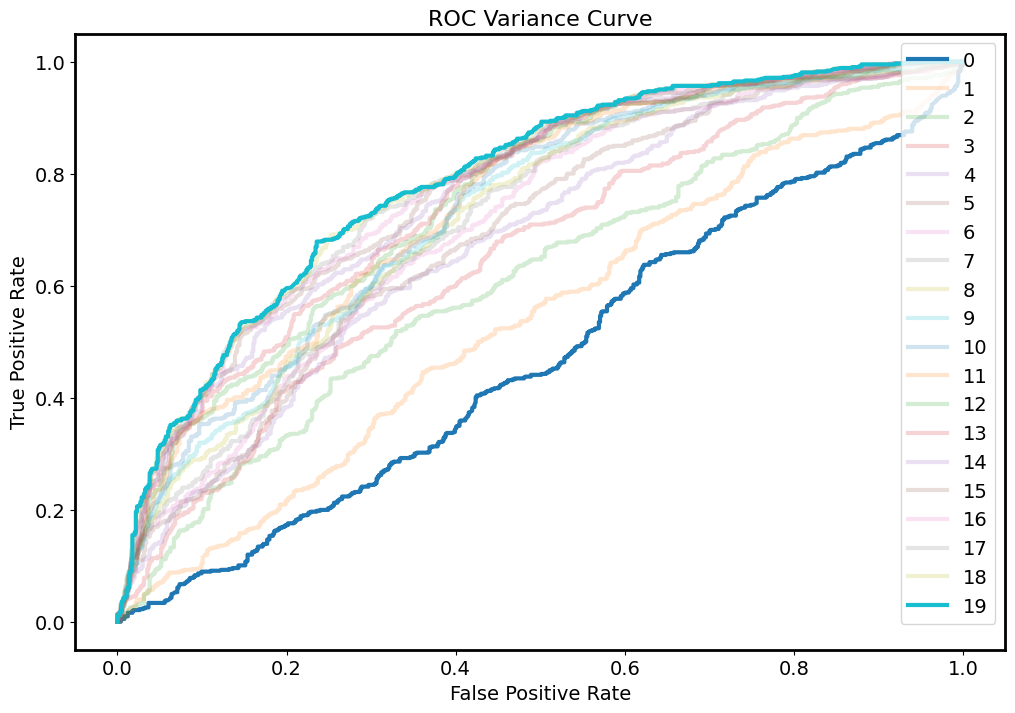

In [ ]:
start = time.time()

# Assign feature arrays to new arrays (just for consistent naming)
trainFeatures, validationFeatures, testFeatures = trainStructured, validationStructured, testStructured

# Create model
denseLayerStructured, modelInputStructured = createFeedForwardNeuralNetwork(trainFeatures, validationFeatures, testFeatures, 5, 32)

# Attach output
structuredNNModel = attachOutputLayerToModel(denseLayerStructured, modelInputStructured)

# Train model
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
EPOCHS = 20
structureNNResults, epochLevelResults, emptyembedding = buildAndTrainModel(structuredNNModel, LEARNING_RATE, BATCH_SIZE, EPOCHS, trainFeatures, validationFeatures, testFeatures, trainingLabels, validationLabels, "FFStructured")

# Results
bestTestAUC = structureNNResults["bestAucScoreTest"]
bestTestAccuracy = structureNNResults["bestTestAccuracy"]
print('Best Test Accuracy: %.3f \nBest Test AUC: %.3f' % (bestTestAccuracy, bestTestAUC))
print("Model training and run time took %d seconds" % (time.time() - start))

########################################################################## Create ROC curve and confusion matrix ##############################################################################
# These are only made in this example, you can copy paste the code in other cells to create the same stuff.
# Create ROC curve
#plt.rcParams['figure.figsize'] = [12, 8] ## plot size
#createROCCurvesForAllEpochs(epochLevelResults, "FeedforwardNeuralNetwork", isVarianceCurve = True)

# Confusion matrix
#plt.cla()
#plt.clf()
#confusionMatrix = structureNNResults["confusionMatrix"]
#displayConfusionMatrix(confusionMatrix)
#plt.show()


### 7.Feedforward Neural Network on FRN Top Features

In [ ]:
#start = time.time()

# Assign feature arrays to new arrays (just for consistent naming)
#trainFeatures, validationFeatures, testFeatures = trainFRN, validationFRN, testFRN

# Create model
#denseLayerFRN, modelInputFRN = createFeedForwardNeuralNetwork(trainFeatures, validationFeatures, testFeatures, 1, 32)

# Attach output
#FRNNNModel = attachOutputLayerToModel(denseLayerFRN, modelInputFRN)

# Train model
#LEARNING_RATE = 0.0001
#BATCH_SIZE = 8
#EPOCHS = 20
#FRNNNResults, FRNEpochLevelResults = buildAndTrainModel(FRNNNModel, LEARNING_RATE, BATCH_SIZE, EPOCHS, trainFeatures, validationFeatures, testFeatures, trainingLabels, validationLabels, "FFFRN")

# Results
#bestTestAUC = FRNNNResults["bestAucScoreTest"]
#bestTestAccuracy = FRNNNResults["bestTestAccuracy"]
#print('Best Test Accuracy: %.3f \nBest Test AUC: %.3f' % (bestTestAccuracy, bestTestAUC))
#print("Model training and run time took %d seconds" % (time.time() - start))

## 7.2 Word CNN

In [68]:
def createWordCNN(trainFeatures, validationFeatures, testFeatures, numConvLayers, vocabularyWords, embeddingsDimensionality, numFilters, kernel, isPreTrainedEmbeddings):
    """Create a word cnn"""

    ## create basic cnn model
    wordInput = Input(shape=trainFeatures.shape[1:], dtype='float32')

    ## word convolutional neural network
    if isPreTrainedEmbeddings == False:
        # Create embeddings using keras built in function.
        wordCNN = tf.keras.layers.Embedding(input_dim=vocabularyWords + 1,
                                   output_dim=embeddingsDimensionality,
                                   input_length=len(trainFeatures[0]),
                                   name = 'embedding')(wordInput)

        # Add CNN layers equal to numConvLayers
        for i in range(numConvLayers):
            wordCNN = tf.keras.layers.Conv1D(numFilters, 2, activation='relu')(wordCNN)
            wordCNN = tf.keras.layers.Dropout(0.5)(wordCNN)
    else:





# multi-kernel parallel CNN layer addition
        conv_blocks = []
        for k in [2,3,5]:
            conv = tf.keras.layers.Conv1D(filters=128, kernel_size=k, activation='relu', padding='same', input_shape=trainFeatures.shape[1:])(wordInput)
            conv_blocks.append(conv)
        # Merge all the kernel outputs
        merged = tf.keras.layers.concatenate(conv_blocks, axis=-1)
        merged = tf.keras.layers.Dropout(0.5)(merged)
        wordCNN = merged





    # GlobalMaxPooling is a good function to use for pooling operations, let's keep it like this
    wordCNN = tf.keras.layers.GlobalMaxPooling1D()(wordCNN)
    #wordCNN = tf.keras.layers.Dropout(0.5)(wordCNN)

    # You can change the number of nodes in the dense layer. Right now, it's set to 64.
    denseLayer = tf.keras.layers.Dense(128)(wordCNN)

    return denseLayer, wordInput




### WordCNN Model Without Pre-trained Embeddings

In [ ]:
start = time.time()

# Create input feature arrays
VOCABULARY_SIZE = 1000
trainFeatures, validationFeatures, testFeatures, WORDS_TO_KEEP, tokenizer = loadDataForWordsWithoutPreTrainedEmbeddings(trainText, validationText, testText, VOCABULARY_SIZE)

# Build WordCNN model
EMBEDDINGS_DIMENSIONALITY = 64
FILTERS_SIZE = 32
KERNEL_SIZE = 3
NUM_CNN_LAYERS = 1
wordCNNDenseLayer, wordCNNInput = createWordCNN(trainFeatures, validationFeatures, testFeatures, NUM_CNN_LAYERS, WORDS_TO_KEEP, EMBEDDINGS_DIMENSIONALITY, FILTERS_SIZE, KERNEL_SIZE, isPreTrainedEmbeddings=False)

# Attach the output layer with the model
wordCNNModel = attachOutputLayerToModel(wordCNNDenseLayer, wordCNNInput)

# Train model
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
EPOCHS = 20
wordCNNResults, wordCNNEpochLevelResults, CNNEmbedding = buildAndTrainModel(wordCNNModel, LEARNING_RATE, BATCH_SIZE, EPOCHS, trainFeatures, validationFeatures, testFeatures, trainingLabels, validationLabels, "WordCNN", return_embedding=True)

# Results
bestTestAUC = wordCNNResults["bestAucScoreTest"]
bestTestAccuracy = wordCNNResults["bestTestAccuracy"]
print('Best Test Accuracy: %.3f \nBest Test AUC: %.3f' % (bestTestAccuracy, bestTestAUC))
print("Model training and run time took %d seconds" % (time.time() - start))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 201)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 201, 64)        │        64,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 32)        │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,545 (283.38 KB)

 Trainable params: 72,545 (283.38 KB)

 Non-trainable params: 0 (0.00 B)

None
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch: 0 
Training: 72.000 
Validation: 71.300

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Writing test predictions for kaggle for epoch 0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 1 
Training: 81.300 
Validation: 80.100

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Writing test predictions for kaggle for epoch 1
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 2 
Training: 84.500 
Validation: 82.900

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Writing test predictions for kaggle for epoch 2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch: 3 
Training: 86.100 
Validation: 84.400

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Writing test predictions for kaggle for epoch 3
75/75 ━━━━━━━

### Word CNN Model with Pre-trained Embeddings

In [58]:
start = time.time()

"""
You might observe that models with pre-trained word embeddings do not perform very well. Therefore, you might want to use these models in conjunction with other models to get a good model. This happens because when we create
pre-trained word embeddings, they are not targeted for a certain task, they are genetic. In contrast, keras.layers.Embeddings creates embeddings based on a specific classification task that the model is trying to solve. Hence,
a mix of generic and targeted embeddings might work well with model fusion and ensembling.
"""

# Create input feature arrays
##################################################### You can set the embedding path to REPRESENTATION EMBEDDINGS too which you can find in "RepresentationEmbeddings" folder ################################
EMBEDDING_PATH = GoogleDriveFolder+"Embeddings/WordEmbeddings.txt"

trainFeatures, validationFeatures, testFeatures, WORDS_TO_KEEP, embeddingDataDictionary = loadDataForWordsWithPreTrainedEmbeddings(trainText, validationText, testText, EMBEDDING_PATH)

# Build WordCNN model
FILTERS_SIZE = 32 # doesn't matter anymore
EMBEDDINGS_DIMENSIONALITY = 64 # doesn't matter anymore
KERNEL_SIZE = 3 # doesn't matter anymore
NUM_CNN_LAYERS = 1 # doesn't matter anymore
wordCNNDenseLayer, wordCNNInput = createWordCNN(trainFeatures, validationFeatures, testFeatures, NUM_CNN_LAYERS, WORDS_TO_KEEP, EMBEDDINGS_DIMENSIONALITY, FILTERS_SIZE, KERNEL_SIZE, isPreTrainedEmbeddings=True)

# Attach the output layer with the model
wordCNNModel = attachOutputLayerToModel(wordCNNDenseLayer, wordCNNInput)

# Train model
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 20
wordCNNResults, epochLevelResultsWordCNN, emptyembedding = buildAndTrainModel(wordCNNModel, LEARNING_RATE, BATCH_SIZE, EPOCHS, trainFeatures, validationFeatures, testFeatures, trainingLabels, validationLabels, "WordCNNWithPretrainedEmbeddings")

# Results
bestTestAUC = wordCNNResults["bestAucScoreTest"]
bestTestAccuracy = wordCNNResults["bestTestAccuracy"]
print('Best Test Accuracy: %.3f \nBest Test AUC: %.3f' % (bestTestAccuracy, bestTestAUC))
print("Model training and run time took %d seconds" % (time.time() - start))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 201, 99)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 201, 128)  │     25,472 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 201, 128)  │     38,144 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 201, 128)  │     63,488 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 201, 384)  │          0 │ conv1d_6[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 201, 384)  │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 384)       │          0 │ dropout_2[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     49,280 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        129 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 176,513 (689.50 KB)

 Trainable params: 176,513 (689.50 KB)

 Non-trainable params: 0 (0.00 B)

None
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch: 0 
Training: 79.300 
Validation: 75.600

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Writing test predictions for kaggle for epoch 0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch: 1 
Training: 87.400 
Validation: 83.400

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Writing test predictions for kaggle for epoch 1
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch: 2 
Training: 92.000 
Validation: 86.900

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Writing test predictions for kaggle for epoch 2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch: 3 
Training: 94.800 
Validation: 88.400

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Writing test predictions for kaggle for epoch 3
75/75 ━━━━━━━━━━━━

In [ ]:
# predict validation set using

## 7.3 LSTM

In [ ]:
def createWordLSTM(trainFeatures, validationFeatures, testFeatures, numLstmLayers, vocabularyWords, embeddingsDimensionality, lstmNodes, bidirectional, isPreTrainedEmbeddings):
    """Create a word lstm"""

    ## create basic cnn model
    wordLSTM = wordInput = layers.Input(shape=trainFeatures.shape[1:], dtype='float32', name = 'wordInput')

    ## word convolutional neural network
    if isPreTrainedEmbeddings == False:
        # Create embeddings using keras built in function.
        wordLSTM = layers.Embedding(input_dim=vocabularyWords + 1,
                                   output_dim=embeddingsDimensionality,
                                   input_length=len(trainFeatures[0]))(wordInput)

        # Add CNN layers
        for i in range(numLstmLayers):


            if( (i==0) and (numLstmLayers==1) ):
                wordLSTM = layers.Bidirectional(layers.LSTM(units=lstmNodes, dropout=0.2, recurrent_dropout=0.2,
                    return_sequences=False))(wordLSTM)
            elif(i != (numLstmLayers-1) ):
                wordLSTM = layers.Bidirectional(layers.LSTM(units=lstmNodes, dropout=0.2, recurrent_dropout=0.2,
                    return_sequences=True))(wordLSTM)
            else:
                wordLSTM = layers.Bidirectional(layers.LSTM(units=lstmNodes, dropout=0.2, recurrent_dropout=0.2,
                    return_sequences=False))(wordLSTM)
    else:

        for i in range(numLstmLayers):


            if( (i==0) and (numLstmLayers==1) ):
                wordLSTM = layers.Bidirectional(layers.LSTM(units=lstmNodes, dropout=0.2, recurrent_dropout=0.2,
                    return_sequences=False))(wordLSTM)
            elif(i != (numLstmLayers-1) ):
                wordLSTM = layers.Bidirectional(layers.LSTM(units=lstmNodes, dropout=0.2, recurrent_dropout=0.2,
                    return_sequences=True))(wordLSTM)
            else:
                wordLSTM = layers.Bidirectional(layers.LSTM(units=lstmNodes, dropout=0.2, recurrent_dropout=0.2,
                    return_sequences=False))(wordLSTM)

    denseLayer = layers.Dense(128)(wordLSTM)


    return denseLayer, wordInput

### Word LSTM Model without Pre-trained Embeddings

In [ ]:
start = time.time()

# Create input feature arrays
VOCABULARY_SIZE = 1000
trainFeatures, validationFeatures, testFeatures, WORDS_TO_KEEP, tokenizer = loadDataForWordsWithoutPreTrainedEmbeddings(trainText, validationText, testText, VOCABULARY_SIZE)

# Build WordLSTM model
EMBEDDINGS_DIMENSIONALITY = 100
LSTM_NODES_IN_LAYERS = 32
NUM_LSTM_LAYERS = 3

#trainFeatures, validationFeatures, testFeatures, numLstmLayers, vocabularyWords, embeddingsDimensionality, lstmNodes, isPreTrainedEmbeddings
wordLSTMDenseLayer, wordLSTMInput = createWordLSTM(trainFeatures, validationFeatures, testFeatures, NUM_LSTM_LAYERS, WORDS_TO_KEEP, EMBEDDINGS_DIMENSIONALITY, LSTM_NODES_IN_LAYERS, bidirectional=True, isPreTrainedEmbeddings=False)

# Attach the output layer with the model
wordLSTMModel = attachOutputLayerToModel(wordLSTMDenseLayer, wordLSTMInput)

# Train model
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 1
wordLSTMResults, epochLevelWordLSTMResults, LSTMEmbedding = buildAndTrainModel(wordLSTMModel, LEARNING_RATE, BATCH_SIZE, EPOCHS, trainFeatures, validationFeatures, testFeatures, trainingLabels, validationLabels, "wordLSTM")

# Results
bestTestAUC = wordLSTMResults["bestAucScoreTest"]
bestTestAccuracy = wordLSTMResults["bestTestAccuracy"]
print('Best Test Accuracy: %.3f \nBest Test AUC: %.3f' % (bestTestAccuracy, bestTestAUC))
print("Model training and run time took %d seconds" % (time.time() - start))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ wordInput (InputLayer)          │ (None, 201)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 201, 100)       │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 201, 64)        │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 201, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,261 (751.02 KB)

 Trainable params: 192,261 (751.02 KB)

 Non-trainable params: 0 (0.00 B)

None


KeyboardInterrupt: 

### Word LSTM with Pre-trained Embeddings

In [ ]:
start = time.time()

# Create input feature arrays
EMBEDDING_PATH = GoogleDriveFolder+"Embeddings/WordEmbeddings.txt"
trainFeatures, validationFeatures, testFeatures, WORDS_TO_KEEP, embeddingDataDictionary = loadDataForWordsWithPreTrainedEmbeddings(trainText, validationText, testText, EMBEDDING_PATH)

# Build WordLSTM model
EMBEDDINGS_DIMENSIONALITY = 64
LSTM_NODES_IN_LAYERS = 16
NUM_LSTM_LAYERS = 1

#trainFeatures, validationFeatures, testFeatures, numLstmLayers, vocabularyWords, embeddingsDimensionality, lstmNodes, isPreTrainedEmbeddings
wordLSTMDenseLayer, wordLSTMInput = createWordLSTM(trainFeatures, validationFeatures, testFeatures, NUM_LSTM_LAYERS, WORDS_TO_KEEP, EMBEDDINGS_DIMENSIONALITY, LSTM_NODES_IN_LAYERS, bidirectional=True, isPreTrainedEmbeddings=True)

# Attach the output layer with the model
wordLSTMModel = attachOutputLayerToModel(wordLSTMDenseLayer, wordLSTMInput)

# Train model
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 1
wordLSTMResults, epochLevelWordLSTMResults, emptyembedding = buildAndTrainModel(wordLSTMModel, LEARNING_RATE, BATCH_SIZE, EPOCHS, trainFeatures, validationFeatures, testFeatures, trainingLabels, validationLabels, "wordLSTMWithPretrainedEmbds")

# Results
bestTestAUC = wordLSTMResults["bestAucScoreTest"]
bestTestAccuracy = wordLSTMResults["bestTestAccuracy"]
print('Best Test Accuracy: %.3f \nBest Test AUC: %.3f' % (bestTestAccuracy, bestTestAUC))
print("Model training and run time took %d seconds" % (time.time() - start))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ wordInput (InputLayer)          │ (None, 201, 99)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,201 (75.00 KB)

 Trainable params: 19,201 (75.00 KB)

 Non-trainable params: 0 (0.00 B)

None
256/256 ━━━━━━━━━━━━━━━━━━━━ 38s 146ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step
Epoch: 0 
Training: 58.700 
Validation: 57.300

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step
Writing test predictions for kaggle for epoch 0
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step
Best Test Accuracy: 0.493 
Best Test AUC: 57.300
Model training and run time took 462 seconds


## 7.4 Char CNN Model

In [69]:
def createCharCNN(trainFeatures, validationFeatures, testFeatures, numConvLayers, numFilters, kernel):
    """Create a char cnn"""

    ## create basic cnn model
    charInput = Input(shape=trainFeatures.shape[1:], dtype='float32')



## parallel kernel concatenation for initial layer
    kernel_sizes = [3,5,7,10]
    conv_blocks = []
    for k in kernel_sizes:
        conv = tf.keras.layers.Conv1D(filters=numFilters, kernel_size=k, activation='relu', input_shape=trainFeatures.shape[1:], padding = 'same')(charInput)
        conv = tf.keras.layers.BatchNormalization()(conv)
        conv_blocks.append(conv)
    # Merge all kernels' outputs
    merged = tf.keras.layers.concatenate(conv_blocks)
    merged = tf.keras.layers.Dropout(0.5)(merged)
    charCNN = merged




# additional layer
    charCNN = tf.keras.layers.Conv1D(numFilters, kernel, activation='relu')(charCNN)
    charCNN = tf.keras.layers.Dropout(0.2)(charCNN)



    charCNN = tf.keras.layers.GlobalMaxPooling1D()(charCNN)


    # You can change the number of nodes in the dense layer. Right now, it's set to 64.
    denseLayer = tf.keras.layers.Dense(64)(charCNN)

    return denseLayer, charInput

In [ ]:
start = time.time()

# Create input feature arrays
MAX_CHARACTERS_TO_KEEP = 100
USE_UPPER_CASE_CHARACTERS = False
trainFeatures, validationFeatures, testFeatures = loadDataForChars(trainText, validationText, testText, MAX_CHARACTERS_TO_KEEP, USE_UPPER_CASE_CHARACTERS)

# Build CharCNN model
EMBEDDINGS_DIMENSIONALITY = 100
FILTERS_SIZE = 64 # for both layers
KERNEL_SIZE = 5 # just for second conv layer
NUM_CNN_LAYERS = 3 # doesn't matter anymore
charCNNDenseLayer, charCNNInput = createCharCNN(trainFeatures, validationFeatures, testFeatures, NUM_CNN_LAYERS, FILTERS_SIZE, KERNEL_SIZE)

# Attach the output layer with the model
charCNNModel = attachOutputLayerToModel(charCNNDenseLayer, charCNNInput)

# Train model
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 20
charCNNResults, epochLevelCharCNNResults, _ = buildAndTrainModel(charCNNModel, LEARNING_RATE, BATCH_SIZE, EPOCHS, trainFeatures, validationFeatures, testFeatures, trainingLabels, validationLabels, "charCNN")

# Results
bestTestAUC = charCNNResults["bestAucScoreTest"]
bestTestAccuracy = charCNNResults["bestTestAccuracy"]
print('Best Test Accuracy: %.3f \nBest Test AUC: %.3f' % (bestTestAccuracy, bestTestAUC))
print("Model training and run time took %d seconds" % (time.time() - start))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 61)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 64)   │     11,776 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 64)   │     19,584 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 100, 64)   │     27,392 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 100, 64)   │     39,104 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 256)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 256)  │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 96, 64)    │     81,984 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 96, 64)    │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_2[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 185,089 (723.00 KB)

 Trainable params: 184,577 (721.00 KB)

 Non-trainable params: 512 (2.00 KB)

None
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch: 0 
Training: 80.700 
Validation: 76.700

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Writing test predictions for kaggle for epoch 0
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch: 1 
Training: 84.500 
Validation: 80.200

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Writing test predictions for kaggle for epoch 1
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch: 2 
Training: 85.800 
Validation: 80.400

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Writing test predictions for kaggle for epoch 2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch: 3 
Training: 87.400 
Validation: 81.800

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Writing test predictions for kaggle for epoch 3
75/75 ━━━━━━━━━━━━

## 7.5 BERT Model

Note: had help from Chat in coding initial BERT model. Tuned architecture from then on

### Base Bert

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the datasets
def tokenize_bert(texts, max_len=500):
    return tokenizer(
        texts,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_encodings = tokenize_bert(trainText)
val_encodings = tokenize_bert(validationText)
test_encodings = tokenize_bert(testText)

In [ ]:
def create_bert_classifier(freeze_bert=True):
    bert_model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)




    if freeze_bert:
        # Freeze all BERT layers initially
        for layer in bert_model.layers:
            layer.trainable = False

# inputs and outputs
    input_ids = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="attention_mask")

    bert_outputs = tf.keras.layers.Lambda(
        lambda x: bert_model(input_ids=x[0], attention_mask=x[1]).last_hidden_state[:, 0, :],
        output_shape=(bert_model.config.hidden_size,)
    )([input_ids, attention_mask])

# dense layers and dropouts
    x = tf.keras.layers.Dropout(0.2)(bert_outputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(optimizer=Adam(learning_rate=.0001),  # slightly higher lr for feature extraction
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])

    return model

# ---------------------------
# Step 1: Feature Extraction Phase
# ---------------------------
bert_model = create_bert_classifier(freeze_bert=True)

# Train only the new top layers first
history = bert_model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=trainingLabels,
    validation_data=(
        {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
        validationLabels
    ),
    epochs=15,  # usually a few epochs
    batch_size=32
)

# ---------------------------
# Step 2: Fine-tuning Phase
# ---------------------------

for layer in bert_model.layers:
    if isinstance(layer, TFBertModel):
        # Unfreeze only last 4 encoder layers
        #for bert_layer in layer.bert.encoder.layer[-4:]:
        layer.trainable = True


# Compile again with lower learning rate for fine-tuning
bert_model.compile(optimizer=Adam(learning_rate=.000001),  # much lower lr
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.AUC()])

# Fine-tune the full model now
fine_tune_history = bert_model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=trainingLabels,
    validation_data=(
        {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
        validationLabels
    ),
    epochs=1,  # only a couple epochs fine-tuning!
    batch_size=32
)

# ---------------------------
# Evaluate
# ---------------------------

bert_results = bert_model.evaluate(
    x={'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    y=validationLabels
)

print(f"BERT Test Accuracy: {bert_results[1]:.4f}, Test AUC: {bert_results[2]:.4f}")

In [ ]:
# Predict probabilities on the test set
predictionsProbsTest = bert_model.predict(
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
    batch_size=16,
    verbose=1
)

# Create a DataFrame and save as CSV
predictions_df = pd.DataFrame({
  "Id": range(1, len(predictionsProbsTest) + 1),
  "Prediction": predictionsProbsTest[:, 0]
})

output_path = GoogleDriveFolder + "AllModelsPredictions/" + "bert_" + "_predictions.csv"
predictions_df.to_csv(output_path, index=False)

### Roberta (classification specific)

In [60]:
from transformers import RobertaTokenizer, RobertaModel

# Load BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the datasets
def tokenize_bert(texts, max_len=500):
    return tokenizer(
        texts,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_encodings = tokenize_bert(trainText)
val_encodings = tokenize_bert(validationText)
test_encodings = tokenize_bert(testText)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [61]:
from transformers import RobertaTokenizer, TFRobertaModel


def create_bert_classifier(freeze_bert=True):
    bert_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)


    # bert-base-uncased

    if freeze_bert:
        # Freeze all BERT layers initially
        for layer in bert_model.layers:
            layer.trainable = False

    input_ids = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="attention_mask")

    bert_outputs = tf.keras.layers.Lambda(
        lambda x: bert_model(input_ids=x[0], attention_mask=x[1]).last_hidden_state[:, 0, :],
        output_shape=(bert_model.config.hidden_size,)
    )([input_ids, attention_mask])

    x = tf.keras.layers.Dropout(0.2)(bert_outputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(optimizer=Adam(learning_rate=.0001),  # slightly higher lr for feature extraction
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])

    return model

# ---------------------------
# Step 1: Feature Extraction Phase
# ---------------------------
bert_model = create_bert_classifier(freeze_bert=True)

# Train only the new top layers first
history = bert_model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=trainingLabels,
    validation_data=(
        {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
        validationLabels
    ),
    epochs=40,  # usually a few epochs
    batch_size=32
)

# ---------------------------
# Step 2: Fine-tuning Phase
# ---------------------------

for layer in bert_model.layers:
    if isinstance(layer, TFBertModel):
        # Unfreeze only last 4 encoder layers
        #for bert_layer in layer.bert.encoder.layer[-4:]:
          layer.trainable = True


# Compile again with lower learning rate for fine-tuning
bert_model.compile(optimizer=Adam(learning_rate=.000001),  # much lower lr
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.AUC()])

# Fine-tune the full model now
fine_tune_history = bert_model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=trainingLabels,
    validation_data=(
        {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
        validationLabels
    ),
    epochs=1,  # only a couple epochs fine-tuning!
    batch_size=32
)

# ---------------------------
# Evaluate
# ---------------------------

bert_results = bert_model.evaluate(
    x={'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    y=validationLabels
)

print(f"BERT Test Accuracy: {bert_results[1]:.4f}, Test AUC: {bert_results[2]:.4f}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 60s 159ms/step - accuracy: 0.5238 - auc: 0.5207 - loss: 0.7126 - val_accuracy: 0.5963 - val_auc: 0.7482 - val_loss: 0.6661
Epoch 2/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.5720 - auc: 0.6068 - loss: 0.6746 - val_accuracy: 0.7397 - val_auc: 0.7852 - val_loss: 0.6433
Epoch 3/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.6044 - auc: 0.6443 - loss: 0.6618 - val_accuracy: 0.7581 - val_auc: 0.8171 - val_loss: 0.6076
Epoch 4/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.6651 - auc: 0.7247 - loss: 0.6247 - val_accuracy: 0.7787 - val_auc: 0.8529 - val_loss: 0.5572
Epoch 5/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.7092 - auc: 0.7734 - loss: 0.5881 - val_accuracy: 0.7993 - val_auc: 0.8782 - val_loss: 0.5104
Epoch 6/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.7402 - auc: 0.8135 - loss: 0.5465 - val_accuracy: 0.8066 - val_auc: 0.8862 - val_loss: 0.4694
Epoch 7/40
256/256 ━━━━━━━━

In [ ]:
# Predict probabilities on the test set
predictionsProbsTest = bert_model.predict(
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
    batch_size=16,
    verbose=1
)

# Create a DataFrame and save as CSV
predictions_df = pd.DataFrame({
  "Id": range(1, len(predictionsProbsTest) + 1),
  "Prediction": predictionsProbsTest[:, 0]
})

output_path = GoogleDriveFolder + "AllModelsPredictions/" + "bert_roberta" + "_predictions.csv"
predictions_df.to_csv(output_path, index=False)

149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step


In [64]:
# Predict probabilities on the valdation data
predictionsProbsVal = bert_model.predict(
    {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    batch_size=16,
    verbose=1
)

# Create a DataFrame and save as CSV
predictions_df_val = pd.DataFrame({
  "Id": range(1, len(predictionsProbsVal) + 1),
  "Prediction": predictionsProbsVal[:, 0]
})

val_output_path = GoogleDriveFolder + "ValidationPredictions/" + "bert_roberta" + "_predictions.csv"
predictions_df_val.to_csv(val_output_path, index=False)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


### Biobert (medical-focused verbage BERT model)

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# Tokenize the datasets
def tokenize_bert(texts, max_len=500):
    return tokenizer(
        texts,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_encodings = tokenize_bert(trainText)
val_encodings = tokenize_bert(validationText)
test_encodings = tokenize_bert(testText)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-efb5c0b5a152>", line 16, in <cell line: 0>
    train_encodings = tokenize_bert(trainText)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-45-efb5c0b5a152>", line 8, in tokenize_bert
    return tokenizer(
           ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py", line 2887, in __call__
    encodings = self._call_one(text=text, text_pair=text_pair, **all_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py", line 2975, in _call_one
    return self.batch_encode_plus(
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel


def create_bert_classifier(freeze_bert=True):
    bert_model = TFBertModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1", from_pt = True)


    # bert-base-uncased

    if freeze_bert:
        # Freeze all BERT layers initially
        for layer in bert_model.layers:
            layer.trainable = False

    input_ids = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="attention_mask")

    bert_outputs = tf.keras.layers.Lambda(
        lambda x: bert_model(input_ids=x[0], attention_mask=x[1]).last_hidden_state[:, 0, :],
        output_shape=(bert_model.config.hidden_size,)
    )([input_ids, attention_mask])

    x = tf.keras.layers.Dropout(0.2)(bert_outputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(optimizer=Adam(learning_rate=.0001),  # slightly higher lr for feature extraction
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])

    return model

# ---------------------------
# Step 1: Feature Extraction Phase
# ---------------------------
bert_model = create_bert_classifier(freeze_bert=True)

# Train only the new top layers first
history = bert_model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=trainingLabels,
    validation_data=(
        {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
        validationLabels
    ),
    epochs=10,  # usually a few epochs
    batch_size=32
)

# ---------------------------
# Step 2: Fine-tuning Phase
# ---------------------------

for layer in bert_model.layers:
    if isinstance(layer, TFBertModel):
        # Unfreeze only last 4 encoder layers
        #for bert_layer in layer.bert.encoder.layer[-4:]:
        layer.trainable = True


# Compile again with lower learning rate for fine-tuning
bert_model.compile(optimizer=Adam(learning_rate=.000001),  # much lower lr
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.AUC()])

# Fine-tune the full model now
fine_tune_history = bert_model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=trainingLabels,
    validation_data=(
        {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
        validationLabels
    ),
    epochs=10,  # only a couple epochs fine-tuning!
    batch_size=32
)

# ---------------------------
# Evaluate
# ---------------------------

bert_results = bert_model.evaluate(
    x={'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    y=validationLabels
)

print(f"BERT Test Accuracy: {bert_results[1]:.4f}, Test AUC: {bert_results[2]:.4f}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 50s 125ms/step - accuracy: 0.5188 - auc_10: 0.5110 - loss: 0.7279 - val_accuracy: 0.6426 - val_auc_10: 0.7570 - val_loss: 0.6459
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.6038 - auc_10: 0.6436 - loss: 0.6577 - val_accuracy: 0.7412 - val_auc_10: 0.8149 - val_loss: 0.5864
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.6593 - auc_10: 0.7268 - loss: 0.6128 - val_accuracy: 0.7662 - val_auc_10: 0.8440 - val_loss: 0.5354
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7022 - auc_10: 0.7695 - loss: 0.5775 - val_accuracy: 0.7743 - val_auc_10: 0.8542 - val_loss: 0.5104
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7142 - auc_10: 0.7872 - loss: 0.5566 - val_accuracy: 0.7868 - val_auc_10: 0.8603 - val_loss: 0.4902
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7328 - auc_10: 0.8067 - loss: 0.5360 - val_accuracy: 0.7846 - val_auc_10: 0.8643 - val_loss

In [ ]:
# Predict probabilities on the test set
predictionsProbsTest = bert_model.predict(
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
    batch_size=16,
    verbose=1
)

# Create a DataFrame and save as CSV
predictions_df = pd.DataFrame({
  "Id": range(1, len(predictionsProbsTest) + 1),
  "Prediction": predictionsProbsTest[:, 0]
})

output_path = GoogleDriveFolder + "AllModelsPredictions/" + "bert_bio" + "_predictions.csv"
predictions_df.to_csv(output_path, index=False)

149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step


### Medical Feedback Bert (patient comments/reviews verbage)

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Tokenize the datasets
def tokenize_bert(texts, max_len=500):
    return tokenizer(
        texts,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_encodings = tokenize_bert(trainText)
val_encodings = tokenize_bert(validationText)
test_encodings = tokenize_bert(testText)

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel


def create_bert_classifier(freeze_bert=True):
    bert_model = TFBertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", from_pt = True)


    # bert-base-uncased

    if freeze_bert:
        # Freeze all BERT layers initially
        for layer in bert_model.layers:
            layer.trainable = False

    input_ids = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="attention_mask")

    bert_outputs = tf.keras.layers.Lambda(
        lambda x: bert_model(input_ids=x[0], attention_mask=x[1]).last_hidden_state[:, 0, :],
        output_shape=(bert_model.config.hidden_size,)
    )([input_ids, attention_mask])

    x = tf.keras.layers.Dropout(0.2)(bert_outputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(optimizer=Adam(learning_rate=.0001),  # slightly higher lr for feature extraction
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])

    return model

# ---------------------------
# Step 1: Feature Extraction Phase
# ---------------------------
bert_model = create_bert_classifier(freeze_bert=True)

# Train only the new top layers first
history = bert_model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=trainingLabels,
    validation_data=(
        {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
        validationLabels
    ),
    epochs=10,  # usually a few epochs
    batch_size=32
)

# ---------------------------
# Step 2: Fine-tuning Phase
# ---------------------------

for layer in bert_model.layers:
    if isinstance(layer, TFBertModel):
        # Unfreeze only last 4 encoder layers
        #for bert_layer in layer.bert.encoder.layer[-4:]:
        layer.trainable = True


# Compile again with lower learning rate for fine-tuning
bert_model.compile(optimizer=Adam(learning_rate=.000001),  # much lower lr
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.AUC()])

# Fine-tune the full model now
fine_tune_history = bert_model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=trainingLabels,
    validation_data=(
        {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
        validationLabels
    ),
    epochs=5,  # only a couple epochs fine-tuning!
    batch_size=32
)

# ---------------------------
# Evaluate
# ---------------------------

bert_results = bert_model.evaluate(
    x={'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    y=validationLabels
)

print(f"BERT Test Accuracy: {bert_results[1]:.4f}, Test AUC: {bert_results[2]:.4f}")

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 49s 125ms/step - accuracy: 0.5382 - auc_12: 0.5467 - loss: 0.7098 - val_accuracy: 0.6824 - val_auc_12: 0.7525 - val_loss: 0.6345
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.6226 - auc_12: 0.6706 - loss: 0.6431 - val_accuracy: 0.7279 - val_auc_12: 0.7937 - val_loss: 0.5841
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.6484 - auc_12: 0.7043 - loss: 0.6255 - val_accuracy: 0.7368 - val_auc_12: 0.8140 - val_loss: 0.5539
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.6849 - auc_12: 0.7523 - loss: 0.5878 - val_accuracy: 0.7551 - val_auc_12: 0.8259 - val_loss: 0.5320
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7156 - auc_12: 0.7758 - loss: 0.5686 - val_accuracy: 0.7566 - val_auc_12: 0.8308 - val_loss: 0.5226
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7047 - auc_12: 0.7729 - loss: 0.5688 - val_accuracy: 0.7654 - val_auc_12: 0.8349 - val_loss

In [ ]:
# Predict probabilities on the test set
predictionsProbsTest = bert_model.predict(
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
    batch_size=16,
    verbose=1
)

# Create a DataFrame and save as CSV
predictions_df = pd.DataFrame({
  "Id": range(1, len(predictionsProbsTest) + 1),
  "Prediction": predictionsProbsTest[:, 0]
})

output_path = GoogleDriveFolder + "AllModelsPredictions/" + "bert_med_notes" + "_predictions.csv"
predictions_df.to_csv(output_path, index=False)

149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step


# 8. Combining Models
## 8.1 Fusing Multiple Deep Learning Models
Most of the time, we do not train a single neural network. Given the power of neural networks, it is usually better to combine a bunch of different models and fuse/ensemble them together to get better results. In this notebook, you can fuse as many models as you like. Below, we show an example of fusing multiple models.

In [72]:

### Structured NN


# Assign feature arrays to new arrays (just for consistent naming)
trainFeaturesStructured, validationFeaturesStructured, testFeaturesStructured = trainStructured, validationStructured, testStructured

# Create model
denseLayerStructured, modelInputStructured = createFeedForwardNeuralNetwork(trainFeaturesStructured, validationFeaturesStructured, testFeaturesStructured, 5, 32)

########################### FRN MODEL
# Assign feature arrays to new arrays (just for consistent naming)
#trainFeaturesGBS, validationFeaturesGBS, testFeaturesGBS = trainFRN, validationFRN, testFRN
# Assign feature arrays to new arrays (just for consistent naming)
#trainFeaturesGBS, validationFeaturesGBS, testFeaturesGBS = trainStructured, validationStructured, testStructured

# Create model
#denseLayerGBS, modelInputGBS = createFeedForwardNeuralNetwork(trainFeaturesGBS, validationFeaturesGBS, testFeaturesGBS, 1, 32)






### Pretrained Embeddings Word CNN


EMBEDDING_PATH = GoogleDriveFolder+"Embeddings/WordEmbeddings.txt"

trainFeaturesWord, validationFeaturesWord, testFeaturesWord, WORDS_TO_KEEP, embeddingDataDictionary = loadDataForWordsWithPreTrainedEmbeddings(trainText, validationText, testText, EMBEDDING_PATH)

# Build WordCNN model
EMBEDDINGS_DIMENSIONALITY = 64
FILTERS_SIZE = 32
KERNEL_SIZE = 3
NUM_CNN_LAYERS = 1
wordCNNDenseLayer, wordCNNInput = createWordCNN(trainFeaturesWord, validationFeaturesWord, testFeaturesWord, NUM_CNN_LAYERS, WORDS_TO_KEEP, EMBEDDINGS_DIMENSIONALITY, FILTERS_SIZE, KERNEL_SIZE, isPreTrainedEmbeddings=True)





### Char CNN


# Create input feature arrays
MAX_CHARACTERS_TO_KEEP = 100
USE_UPPER_CASE_CHARACTERS = False
trainFeaturesChar, validationFeaturesChar, testFeaturesChar = loadDataForChars(trainText, validationText, testText, MAX_CHARACTERS_TO_KEEP, USE_UPPER_CASE_CHARACTERS)

# Build CharCNN model
EMBEDDINGS_DIMENSIONALITY = 100
FILTERS_SIZE = 64
KERNEL_SIZE = 5
NUM_CNN_LAYERS = 3
charCNNDenseLayer, charCNNInput = createCharCNN(trainFeaturesChar, validationFeaturesChar, testFeaturesChar, NUM_CNN_LAYERS, FILTERS_SIZE, KERNEL_SIZE)













########################## FUSION
# Now that we have dense layers from different models, we can concatenate them together. This will make the model leverage all individual models during training.
# We call the 'concatenateModels' function that takes as parameter a list of dense layers from different neural networks and concatenates them together.
concatenatedDenseLayer = concatenateModels([denseLayerStructured, charCNNDenseLayer, wordCNNDenseLayer])

# Now, we need to attach the output layer to the concatenated model. Here, we pass the concatenated layer to the first argument and a list of inputs of concatenated models to the second argument. You should notice
# the difference between attachOutputLayerToModel in separate models above vs the concatenated model below
concatenatedCNNModel = attachOutputLayerToModel(concatenatedDenseLayer, [modelInputStructured, charCNNInput, wordCNNInput])

######################## TRAINING
# Train model
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
EPOCHS = 60

# Below, instead of passing a single trainFeatures list, we now need to pass feature lists from both of our models that we have concatenated. Notice the difference in the line below between separate and fused models.
# The order of the input is very important here. During concatenation, the order we use in the input list has to be the same that we use below during training while inputting the training, testing, and validation inputs.
concatenatedModelResults, epochLevelResultsCombinedModel, _ = buildAndTrainModel(concatenatedCNNModel, LEARNING_RATE, BATCH_SIZE, EPOCHS, [trainFeaturesStructured, trainFeaturesChar, trainFeaturesWord],
                                              [validationFeaturesStructured, validationFeaturesChar, validationFeaturesWord], [testFeaturesStructured, testFeaturesChar, testFeaturesWord], trainingLabels, validationLabels, "combinedModel")





# Results
bestTestAUC = concatenatedModelResults["bestAucScoreTest"]
bestTestAccuracy = concatenatedModelResults["bestTestAccuracy"]
print('Best Test Accuracy: %.3f \nBest Test AUC: %.3f' % (bestTestAccuracy, bestTestAUC))

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 222)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      7,136 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 32)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │      1,056 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 100, 61)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │      1,056 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 100, 64)   │     11,776 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 100, 64)   │     19,584 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 100, 64)   │     27,392 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 100, 64)   │     39,104 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 32)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 64)   │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │      1,056 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 100, 256)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 201, 99)   │          0 │ -               

 Total params: 374,049 (1.43 MB)

 Trainable params: 373,537 (1.42 MB)

 Non-trainable params: 512 (2.00 KB)

None
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Epoch: 0 
Training: 71.800 
Validation: 68.700

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Writing test predictions for kaggle for epoch 0
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch: 1 
Training: 76.900 
Validation: 74.500

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Writing test predictions for kaggle for epoch 1
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch: 2 
Training: 79.500 
Validation: 76.900

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Writing test predictions for kaggle for epoch 2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch: 3 
Training: 81.700 
Validation: 79.300

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Writing test predictions for kaggle for epoch 3
75/75 ━━━━━━━━━━

## 8.2 Ensembling Models
In class, we learned the difference between ensembling and fusion. Ensembling usually works very well if you can find the right weights for each model (always start with equal weights, for example 0.5 if ensembling two models). Below is an example of ensembling multiple (two) models.

In [ ]:
######## If you go SavedModels folder, you'll observe that all the best model predictions are saved there. You can combine them to make an ensemble.

In [ ]:
modelOnePredictions = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"AllModelsPredictions/WordCNNPretrained.csv", sep=",")).values.tolist() # Word CNN final
modelTwoPredictions = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"AllModelsPredictions/bert_predictions.csv", sep=",")).values.tolist() # Base BERT final
modelThreePredictions = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"AllModelsPredictions/CharCNN.csv", sep=",")).values.tolist() # Char CNN final
modelFourPredictions = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"AllModelsPredictions/StructuredNN.csv", sep=",")).values.tolist() # Structured NN final
modelFivePredictions = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"AllModelsPredictions/Concat.csv", sep=",")).values.tolist() # Concat final
modelSixPredictions = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"AllModelsPredictions/bert_bio_predictions.csv", sep=",")).values.tolist() # Bert Bio final
modelSevenPredictions = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"AllModelsPredictions/bert_med_notes_predictions.csv", sep=",")).values.tolist() # Bert Bio Patient Reviews final
modelEightPredictions = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"AllModelsPredictions/BERT.csv", sep=",")).values.tolist() # Roberta final


# final version: 40% Concat and 60% Roberta
weightOne = 0
weightTwo = 0
weightThree = 0
weightFour = 0
weightFive = .4
weightSix = 0
weightSeven = 0
weightEight = .6

"""To add more models, just add a few more lines and use them during average. For instance, adding a third model would require 2 more lines above. modelThreePredictions and weightThree. Next, you only need to
use the predictions from that during averaging below. We will have 'average = (weightOne * modelOnePredictions[i][1]) + (weightTwo * modelTwoPredictions[i][1]) + (weightThree * modelThreePredictions[i][1])' """


averagePredictions = []

for i in range(0, len(modelOnePredictions)):
    average = (weightOne * modelOnePredictions[i][1]) + (weightTwo * modelTwoPredictions[i][1]) + (weightThree * modelThreePredictions[i][1]) + (weightFour * modelFourPredictions[i][1]) + (weightFive * modelFivePredictions[i][1]) + (weightSix * modelSixPredictions[i][1]) + (weightSeven * modelSevenPredictions[i][1]) + (weightEight * modelEightPredictions[i][1])
    averagePredictions.append(average)

averageHardPredictions = [1 if item >= 0.5 else 0 for item in averagePredictions]

# Create file for kaggle submission
#kaggleFile = open(GoogleDriveFolder+"AllModelsPredictions/ensemble_predictions.txt","w")
#kaggleFile.write("Id,Prediction\n")
#for i in range(0, len(averagePredictions)):
#    kaggleFile.write(str(i+1) + "," + str(averagePredictions[i]) + "\n")
#kaggleFile.close()


# Create file for Kaggle submission
submission_df = pd.DataFrame({
    "Id": range(1, len(averagePredictions) + 1),
    "Prediction": averagePredictions
})

output_path = GoogleDriveFolder + "AllModelsPredictions/ensemble_predictions.csv"
submission_df.to_csv(output_path, index=False)

In [116]:
concatValidPred = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"ValidationPredictions/combinedModel_predictions.csv", sep=",")).values.tolist() # Word CNN final
robertaValidPred = pd.DataFrame(pd.read_csv(GoogleDriveFolder+"ValidationPredictions/bert_roberta_predictions.csv", sep=",")).values.tolist() # Base BERT final


# final version: 40% Concat and 60% Roberta
weightOne = .4
weightTwo = .6


"""To add more models, just add a few more lines and use them during average. For instance, adding a third model would require 2 more lines above. modelThreePredictions and weightThree. Next, you only need to
use the predictions from that during averaging below. We will have 'average = (weightOne * modelOnePredictions[i][1]) + (weightTwo * modelTwoPredictions[i][1]) + (weightThree * modelThreePredictions[i][1])' """


averagePredictions = []

for i in range(0, len(concatValidPred)):
    average = (weightOne * concatValidPred[i][1]) + (weightTwo * robertaValidPred[i][1])
    averagePredictions.append(average)

averageHardPredictions = [1 if item >= 0.5 else 0 for item in averagePredictions]

# Create file for kaggle submission
#kaggleFile = open(GoogleDriveFolder+"AllModelsPredictions/ensemble_predictions.txt","w")
#kaggleFile.write("Id,Prediction\n")
#for i in range(0, len(averagePredictions)):
#    kaggleFile.write(str(i+1) + "," + str(averagePredictions[i]) + "\n")
#kaggleFile.close()


# Create file for Kaggle submission
submission_df = pd.DataFrame({
    "Id": range(1, len(averagePredictions) + 1),
    "Prediction": averagePredictions
})

output_path = GoogleDriveFolder + "ValidationPredictions/ensemble_predictions.csv"
submission_df.to_csv(output_path, index=False)

## 9. Visualizing Word Embeddings

### 9.1 Pretrained Embeddings

In [ ]:
embedding_df = pd.DataFrame.from_dict(embeddingDataDictionary, orient = 'index')
embedding_df.shape

(20115, 63)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns

def visualize_pretrained_embeddings(k):
    #can try different values of k to increase number of clusters

    #leave n_components at 2
    tsne = TSNE(n_components = 2, random_state = 123)
    tsne_array = tsne.fit_transform(embedding_df)

    # Create a DataFrame for plotting with t-SNE results
    tsne_df = pd.DataFrame(tsne_array, columns=['x', 'y'], index=embedding_df.index)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters = k, random_state = 456).fit(tsne_array)
    tsne_df['cluster'] = kmeans.labels_

    plot = sns.scatterplot(data=tsne_df, x='x', y='y', hue='cluster')

    return plot


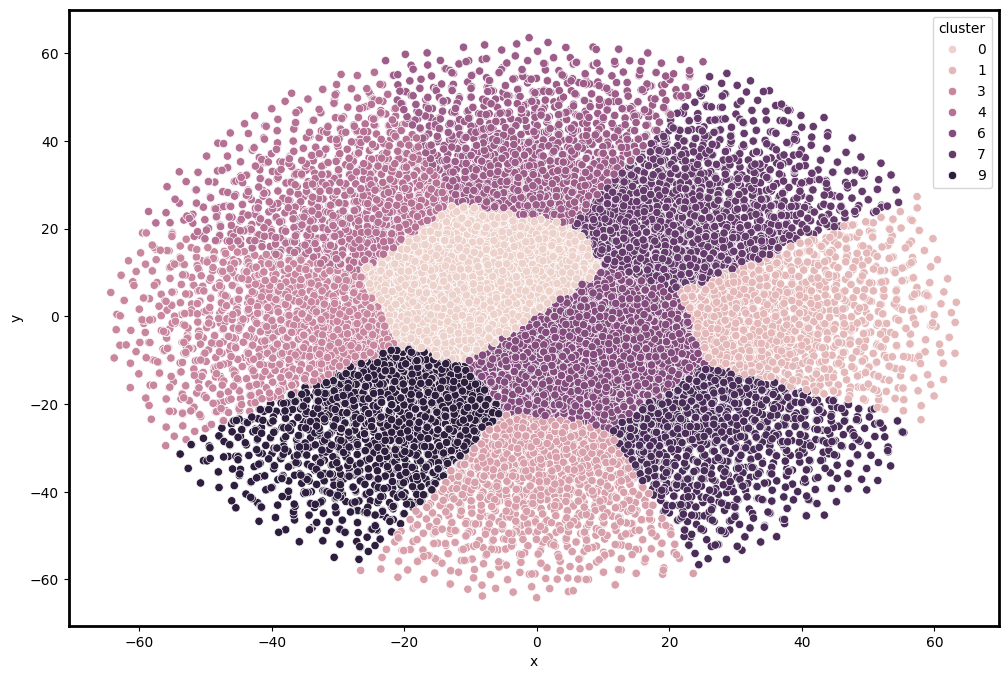

In [ ]:
plot = visualize_pretrained_embeddings(k = 10)

### 9.2 Keras Embedding Layer

In [ ]:
CNNEmbedding_df = pd.DataFrame(CNNEmbedding, index = tuple(tokenizer.word_index)[:CNNEmbedding.shape[0]])

In [ ]:
def visualize_keras_embedding(k = 5):

    #can try different values of k to increase number of clusters
    #leave n_components at 2
    tsne = TSNE(n_components = 2, random_state = 12)
    tsne_array = tsne.fit_transform(CNNEmbedding_df)

    kmeans = KMeans(n_clusters = k, random_state = 23).fit(tsne_array)

    clusters = kmeans.labels_

     # Create a DataFrame for plotting
    plot_df = pd.DataFrame(tsne_array, columns=['x', 'y'])
    plot_df['cluster'] = clusters

    # Use the DataFrame for scatterplot
    plot_result = sns.scatterplot(x='x', y='y', hue='cluster', data=plot_df)

    return plot_result

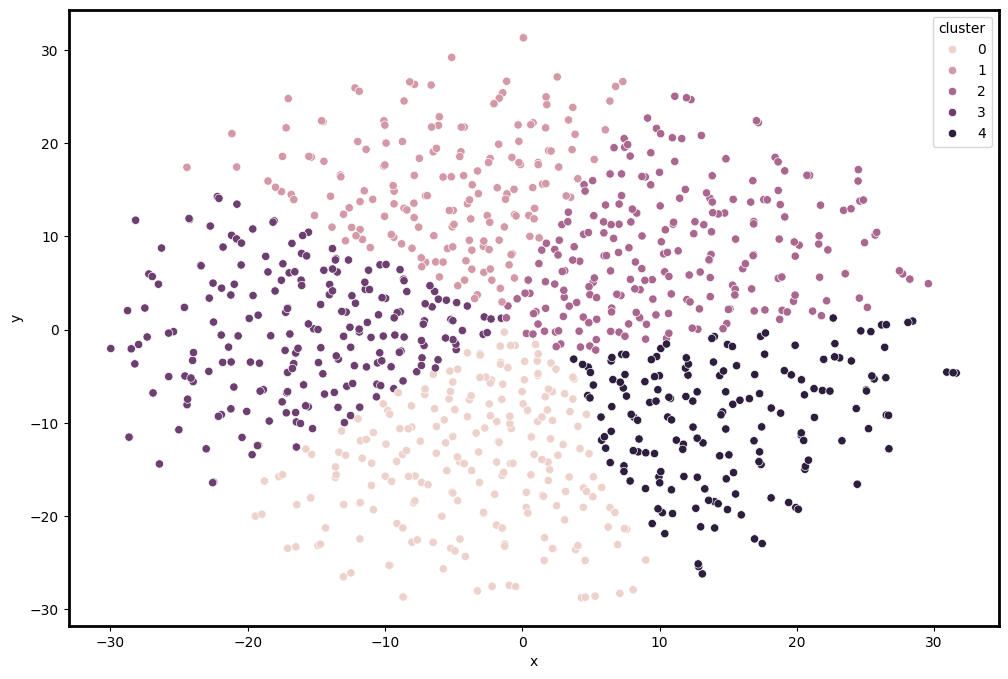

In [ ]:
plot = visualize_keras_embedding(k = 5)

Note: do analysis on subgroups from structured data using final predictions

## 10. Subgroup Analysis

In [121]:
# load in valid prediction csvs
file_path = GoogleDriveFolder + "ValidationPredictions/ensemble_predictions.csv"
ensemble_preds_df = pd.read_csv(file_path)
ensemble_preds = ensemble_preds_df['Prediction']
ensemble_preds = ensemble_preds.to_numpy()

file_path = GoogleDriveFolder + "ValidationPredictions/combinedModel_predictions.csv"
concat_preds_df = pd.read_csv(file_path)
concat_preds = concat_preds_df['Prediction']
concat_preds = concat_preds.to_numpy()

file_path = GoogleDriveFolder + "ValidationPredictions/bert_roberta_predictions.csv"
roberta_preds_df = pd.read_csv(file_path)
roberta_preds = roberta_preds_df['Prediction']
roberta_preds = roberta_preds.to_numpy()

file_path = GoogleDriveFolder + "ValidationPredictions/WordCNNWithPretrainedEmbeddings_predictions.csv"
word_cnn_preds_df = pd.read_csv(file_path)
word_cnn_preds = word_cnn_preds_df['Prediction']
word_cnn_preds = word_cnn_preds.to_numpy()


In [132]:
print("Labels length:", len(validationLabels))
for name, preds in models.items():
    print(f"{name} predictions length: {len(preds)}")


Labels length: 1360
Ensemble predictions length: 1360
CombinedModel predictions length: 1360
Roberta predictions length: 1360
WordCNN predictions length: 1360


In [131]:
# masks for groups (taken from earlier in code when structured data is loaded in)

group_masks = {
    'Stimulant': is_stimulant,
    'Autoimmune': is_autoimmune,
    'CNS': is_cns,
    'Under 21': is_u21,
    '21–35': is_21_to_35,
    '36–50': is_36_to_50,
    '51+': is_51_over
}



# model preds
models = {
    'Ensemble': ensemble_preds,
    'CombinedModel': concat_preds,
    'Roberta': roberta_preds,
    'WordCNN': word_cnn_preds
}



# helper function to compute accuracy measures
def evaluate_predictions(preds, labels, top_percentiles=[5, 10, 20, 40]):
    results = {'AUC': roc_auc_score(labels, preds)}
    sorted_indices = np.argsort(preds)
    total = len(preds)
    for p in top_percentiles:
        k = int(np.ceil(p / 100 * total))

        top_pos_idx = sorted_indices[-k:]
        top_neg_idx = sorted_indices[:k]

        acc_pos = accuracy_score(labels[top_pos_idx], preds[top_pos_idx] >= 0)
        acc_neg = accuracy_score(labels[top_neg_idx], preds[top_neg_idx] < 0)

        results[f'Acc_Pos_Top{p}%'] = acc_pos
        results[f'Acc_Neg_Top{p}%'] = acc_neg
    return results




# overall results by model
overall_results = {}
for model_name, preds in models.items():
    overall_results[model_name] = evaluate_predictions(preds, validationLabels)

overall_results_df = pd.DataFrame(overall_results).T
print("=== Overall Model Performance ===")
print(overall_results_df)




# group results by model
group_results_dict = {}

for group_name, mask in group_masks.items():
    group_results = {}
    for model_name, preds in models.items():
        group_labels = validationLabels[mask]
        group_preds = preds[mask]
        if len(group_labels) > 0:
            group_results[model_name] = evaluate_predictions(group_preds, group_labels)
        else:
            group_results[model_name] = {'AUC': None}
    group_results_dict[group_name] = pd.DataFrame(group_results).T


# display
for group_name, df in group_results_dict.items():
    print(f"\n=== Group: {group_name} ===")
    print(df)




=== Overall Model Performance ===
                    AUC  Acc_Pos_Top5%  Acc_Neg_Top5%  Acc_Pos_Top10%  \
Ensemble       0.946594       1.000000       1.000000        0.992647   
CombinedModel  0.927745       0.985294       0.985294        0.933824   
Roberta        0.921952       1.000000       0.970588        0.985294   
WordCNN        0.913827       0.985294       0.985294        0.970588   

               Acc_Neg_Top10%  Acc_Pos_Top20%  Acc_Neg_Top20%  Acc_Pos_Top40%  \
Ensemble             0.992647        0.974265        0.985294        0.913603   
CombinedModel        0.977941        0.948529        0.985294        0.880515   
Roberta              0.985294        0.966912        0.970588        0.878676   
WordCNN              0.985294        0.966912        0.974265        0.863971   

               Acc_Neg_Top40%  
Ensemble             0.952206  
CombinedModel        0.943015  
Roberta              0.924632  
WordCNN              0.913603  

=== Group: Stimulant ===
        